# Anomaly Detection on Synthetic Data - Setting up Cross-Validation
In this notebook, we ...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_anomaly_AA.ipynb)

In [1]:
random_state = None

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    aabb_classification_benchmark,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from LogFilterbank import LogFilterbank
from manifold_utils import tsne_embedding

time passed: 5.36 s
downloading synthetic data successful: True


# Data Loading

In [5]:
X, y = load_syn_reg_data(data_path=SYN_DATA_PATH,
                         min_radius = 1.9,
                         cache=True)

In [6]:
Xpos = X[y==0.0]
Xneg = X[y>0.0]

## Combine positive (normal) and negative (anomaly) samples and generate ground truth labels

In [7]:
X, y = CreateAnomalyData(Xpos, Xneg)

## Check label distribution
Positive examples are pristine samples and labelled as "1", outliers are labelled as "-1"

In [8]:
ctr = Counter(y)
ctr

Counter({1.0: 990, -1.0: 27312})

# A-A Testing
If we use the same method, we want to see highly similar results. Otherwise, a comparison between methods will not give meaningful and reproducable results.

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline

## Anomaly Detection-specific scoring

In [10]:
scoring = get_anomaly_scoring()

## Setting up the Pipeline
Notice, in our case it is not required to perform feature scaling, so creating a pipeline could be considered unnessesary. However, in case we want to try something more complex, it is easier to have a pipeline already set up.

In [11]:
estimator = OneClassSVM(gamma='scale')
pipeline = Pipeline([('est', estimator)])

n_repeats = 5
pipelines = repeat_experiment(pipeline, n_repeats=n_repeats, name="OneClassSVM")

## Create CV splits for each model instance separately
We need different training and validation data for each model to confirm that we get reproducable results that are independent from each other, but highly similar.
We can visually confirm that we actually have different splits. Be aware, we focus on the first 2000 indices for clarity, where the first 990 are the positive samples.

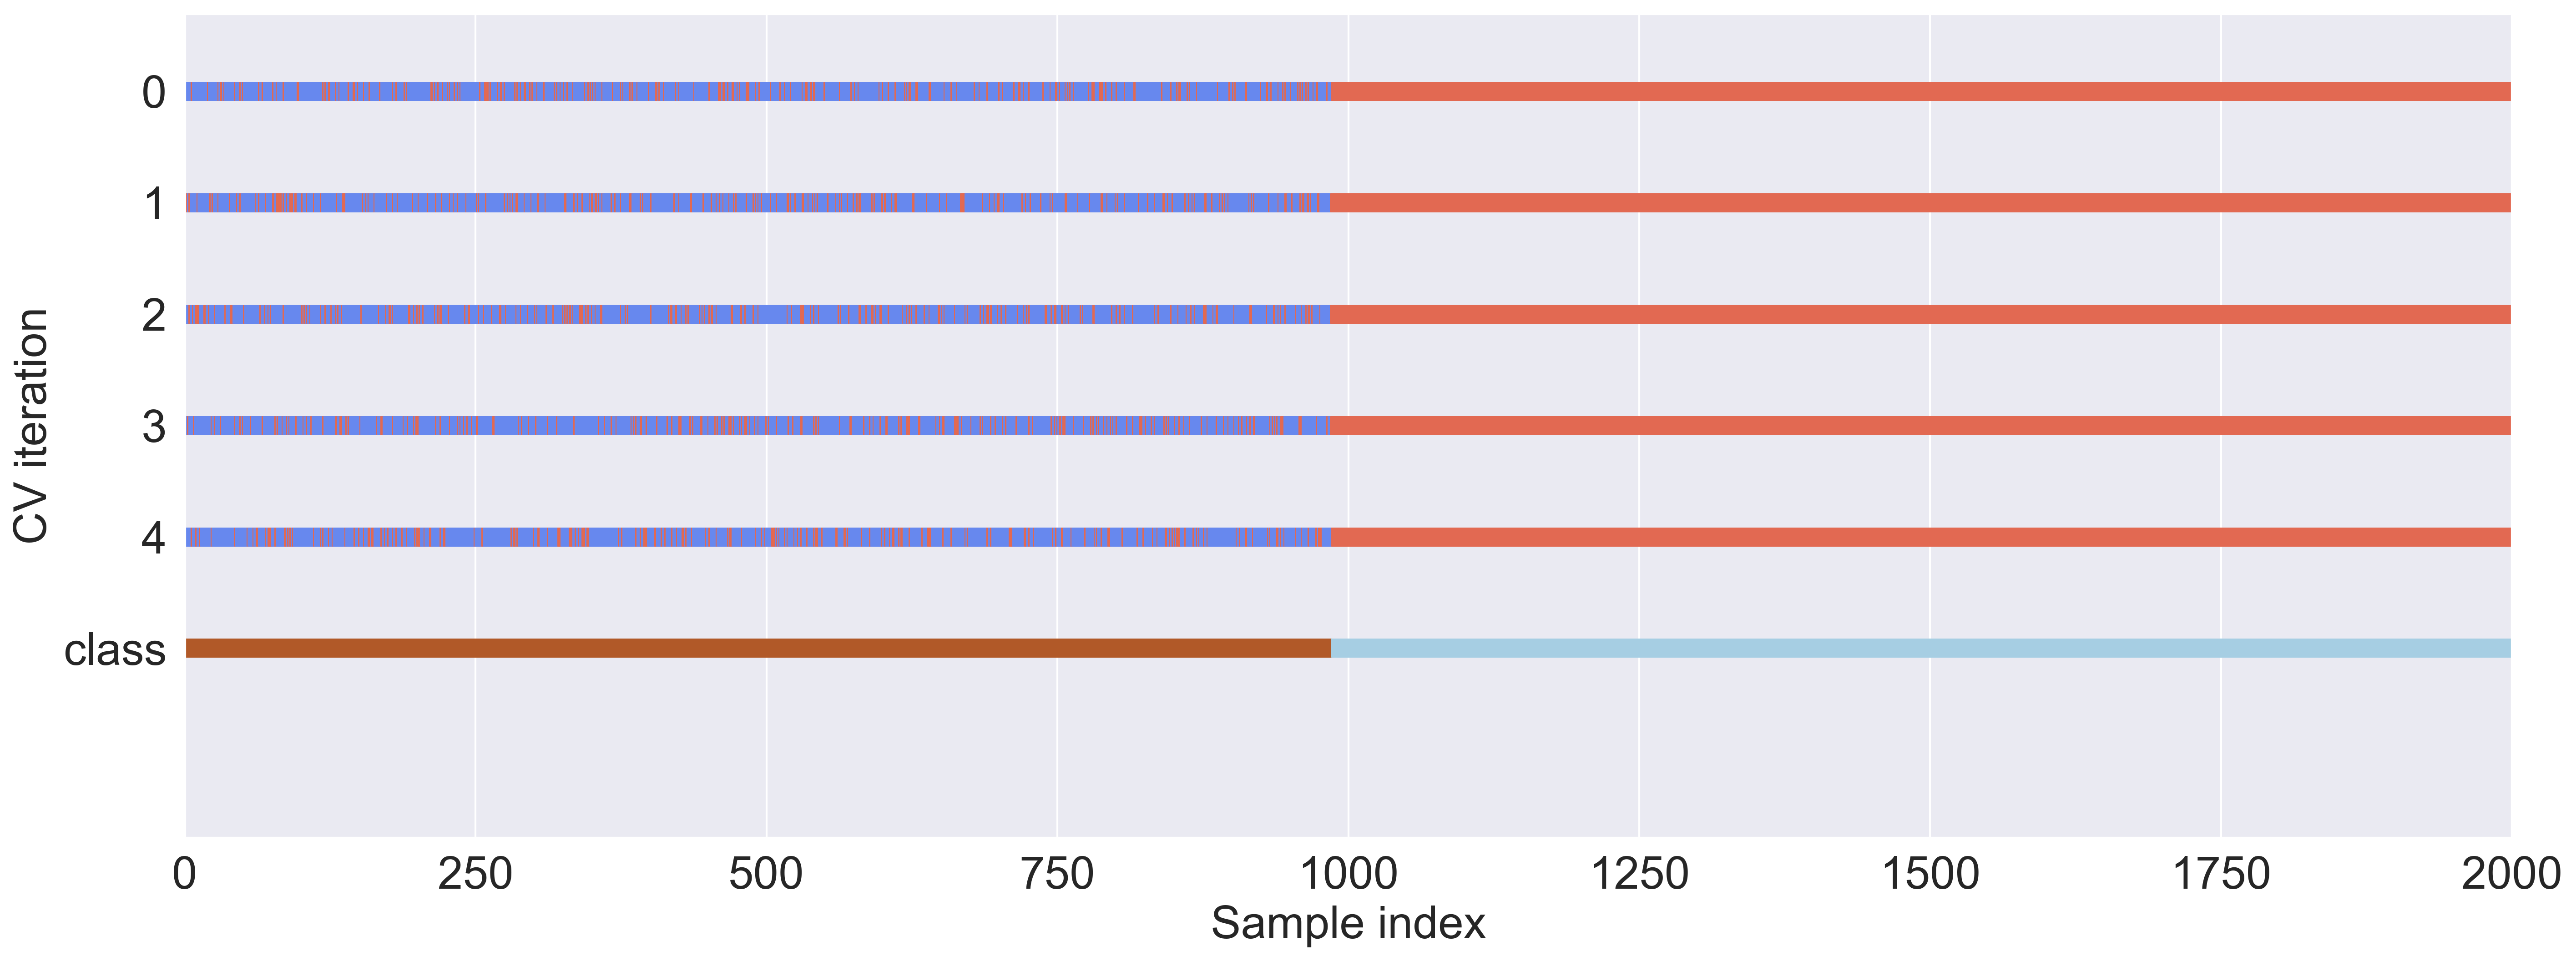

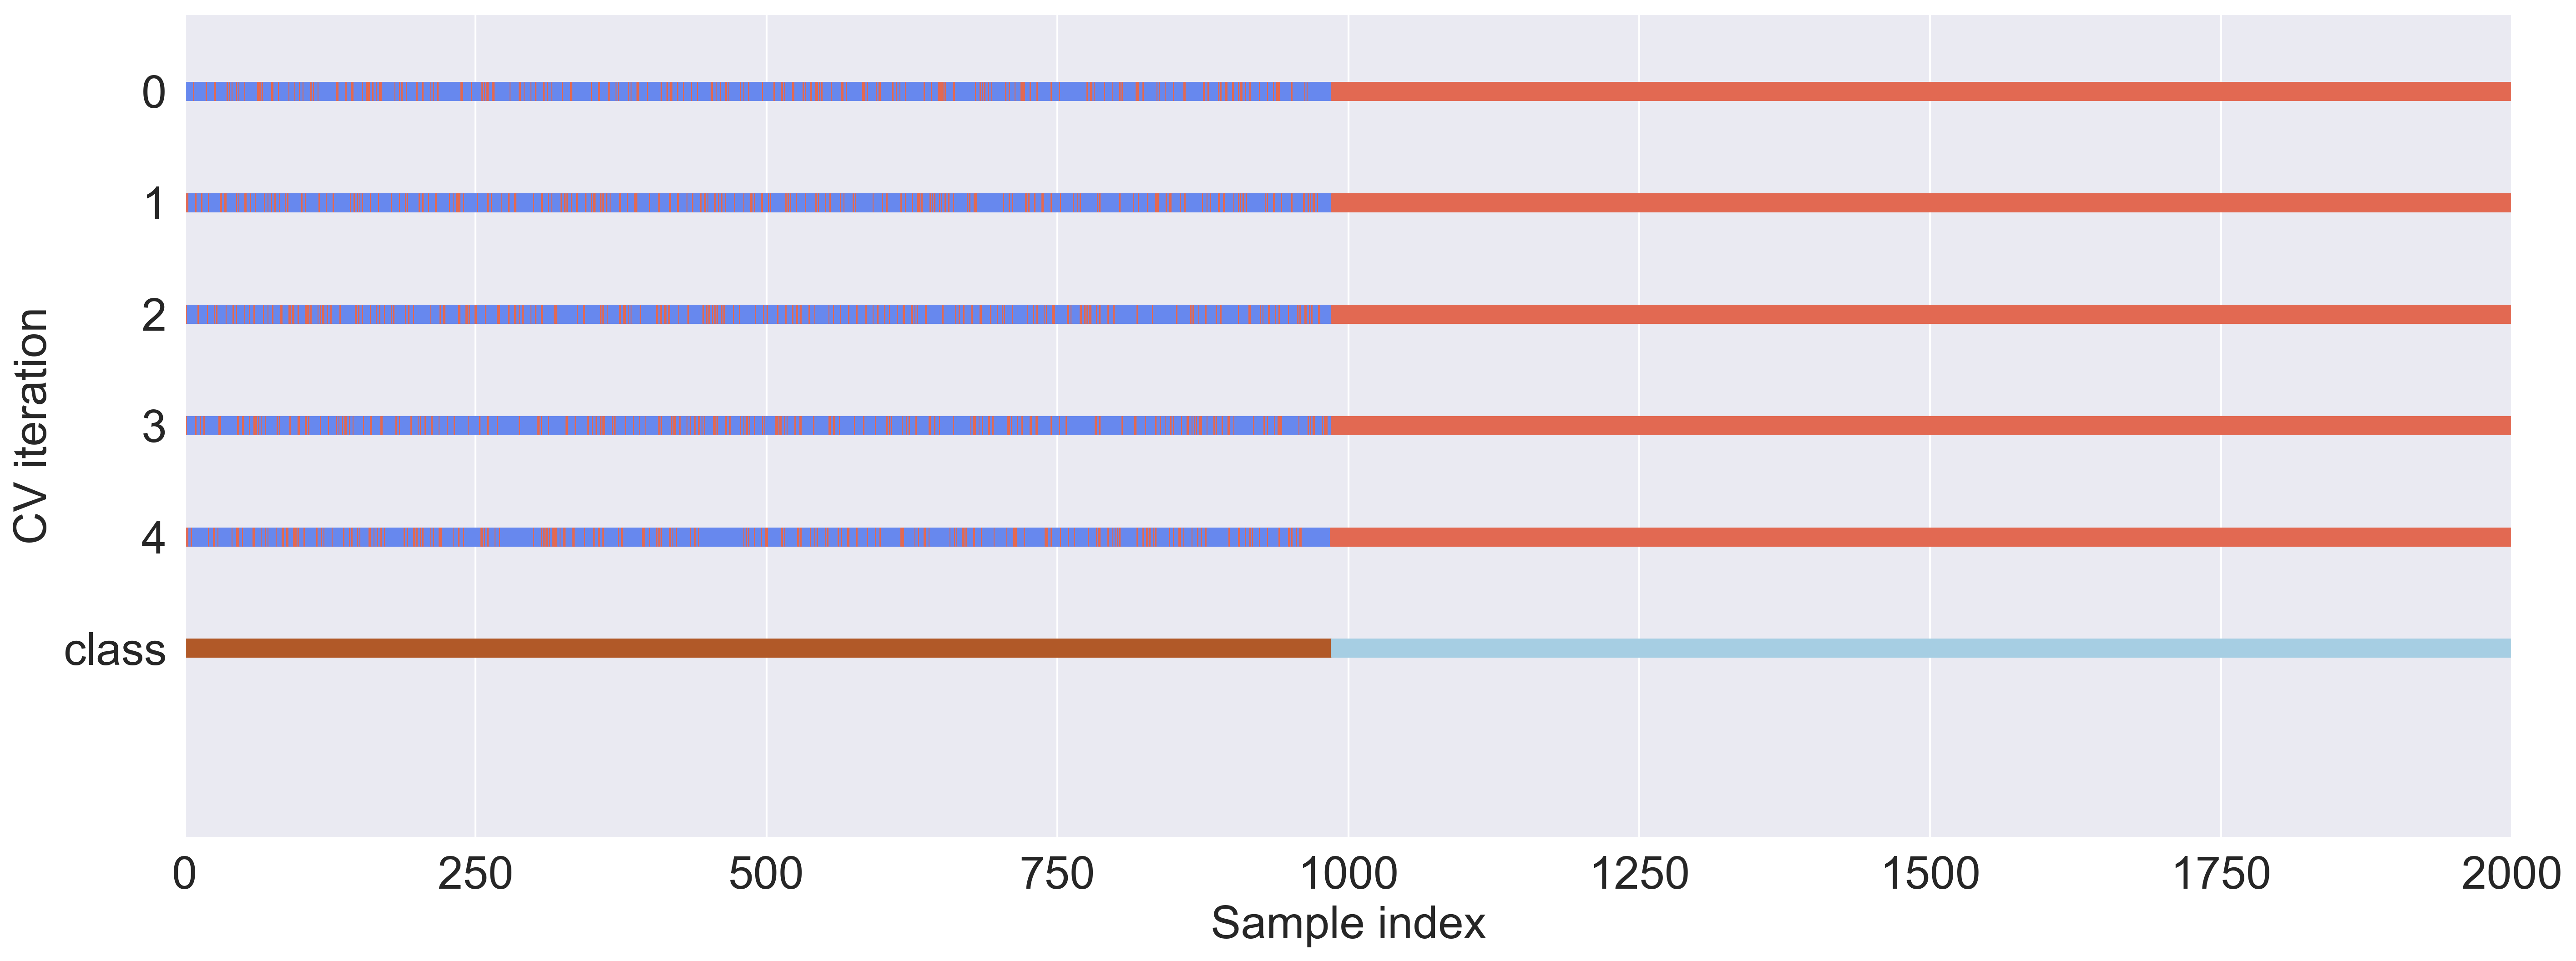

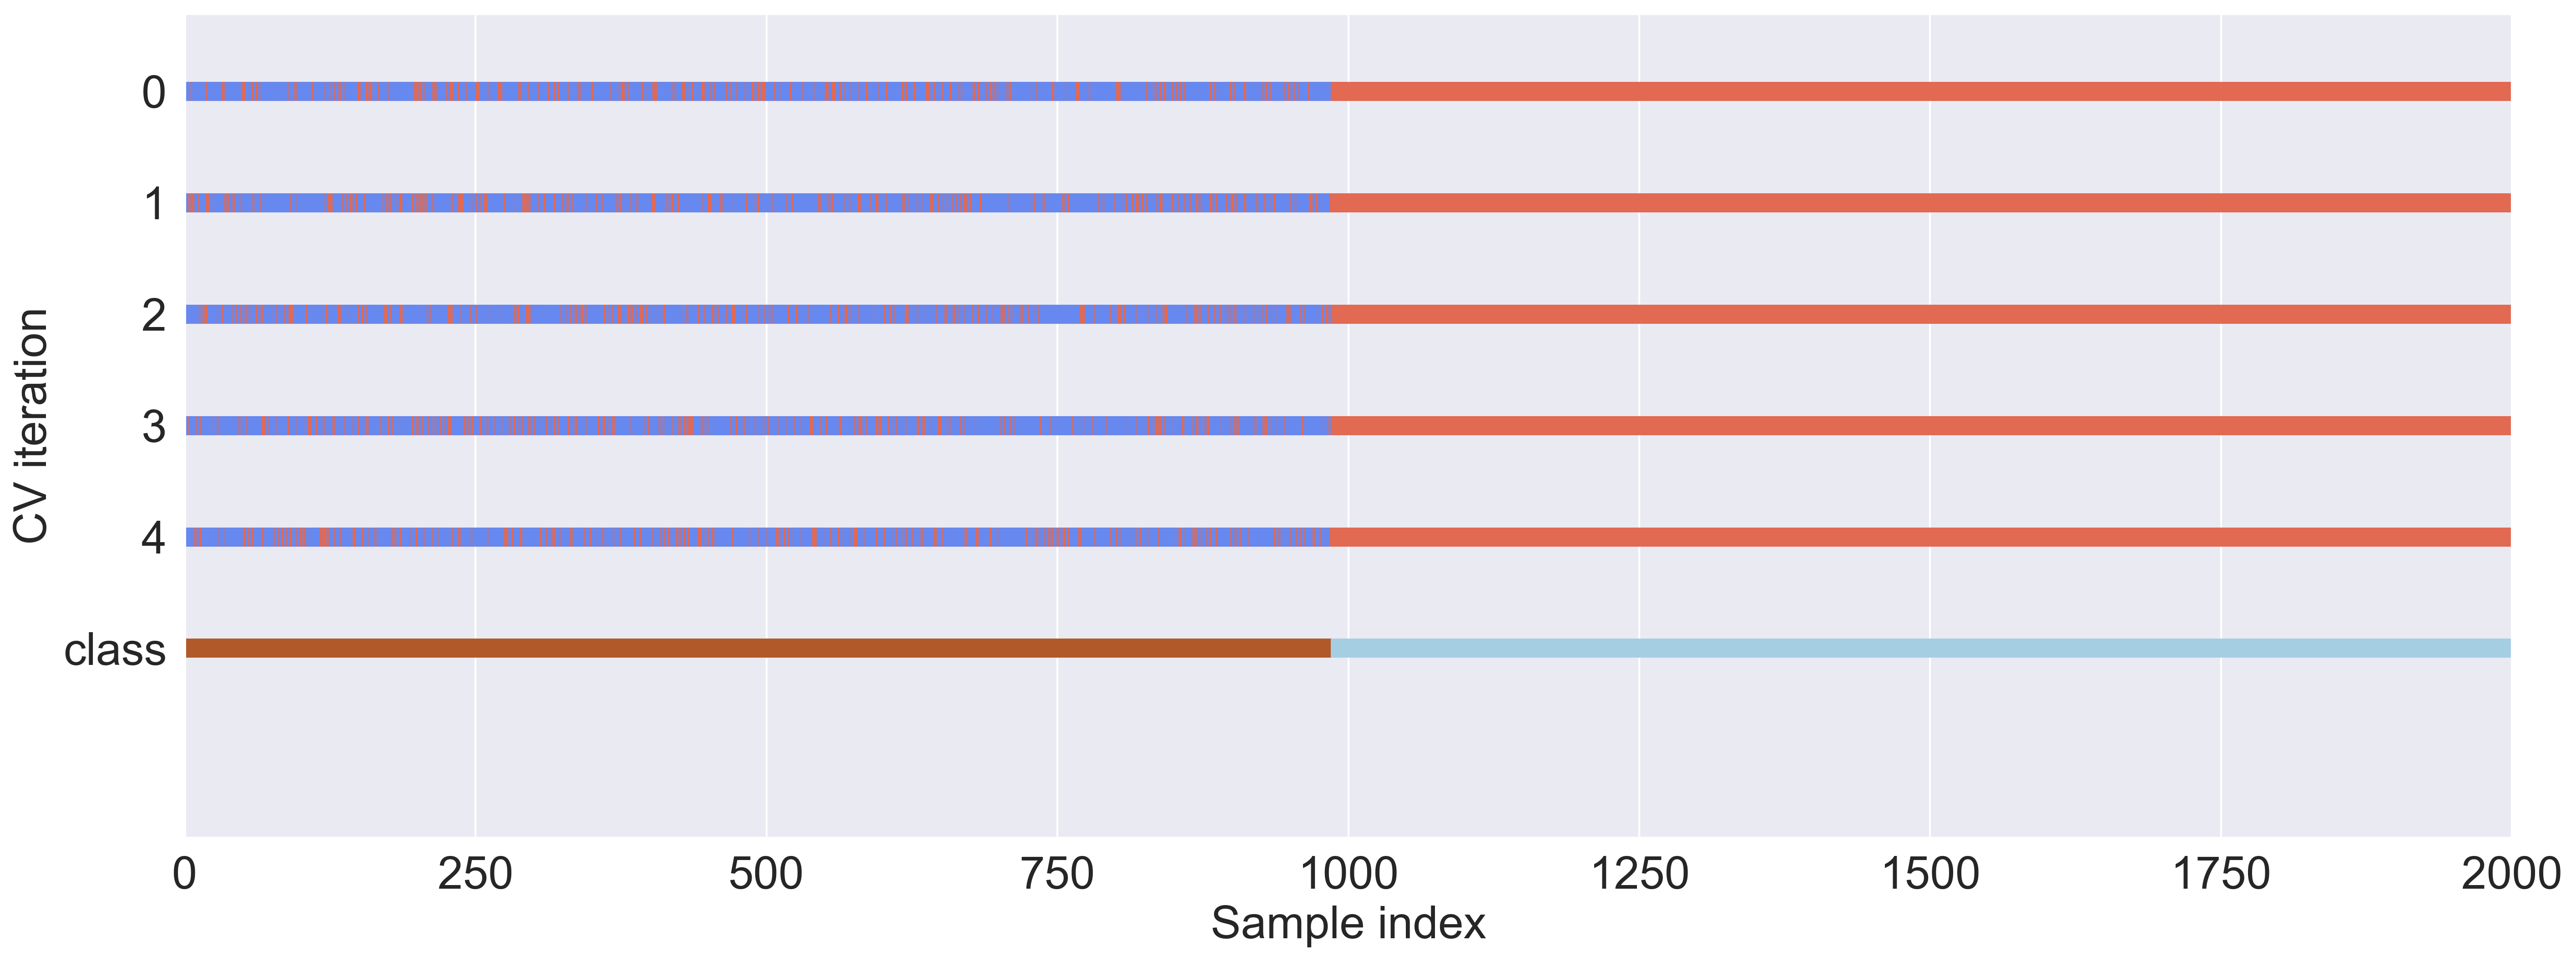

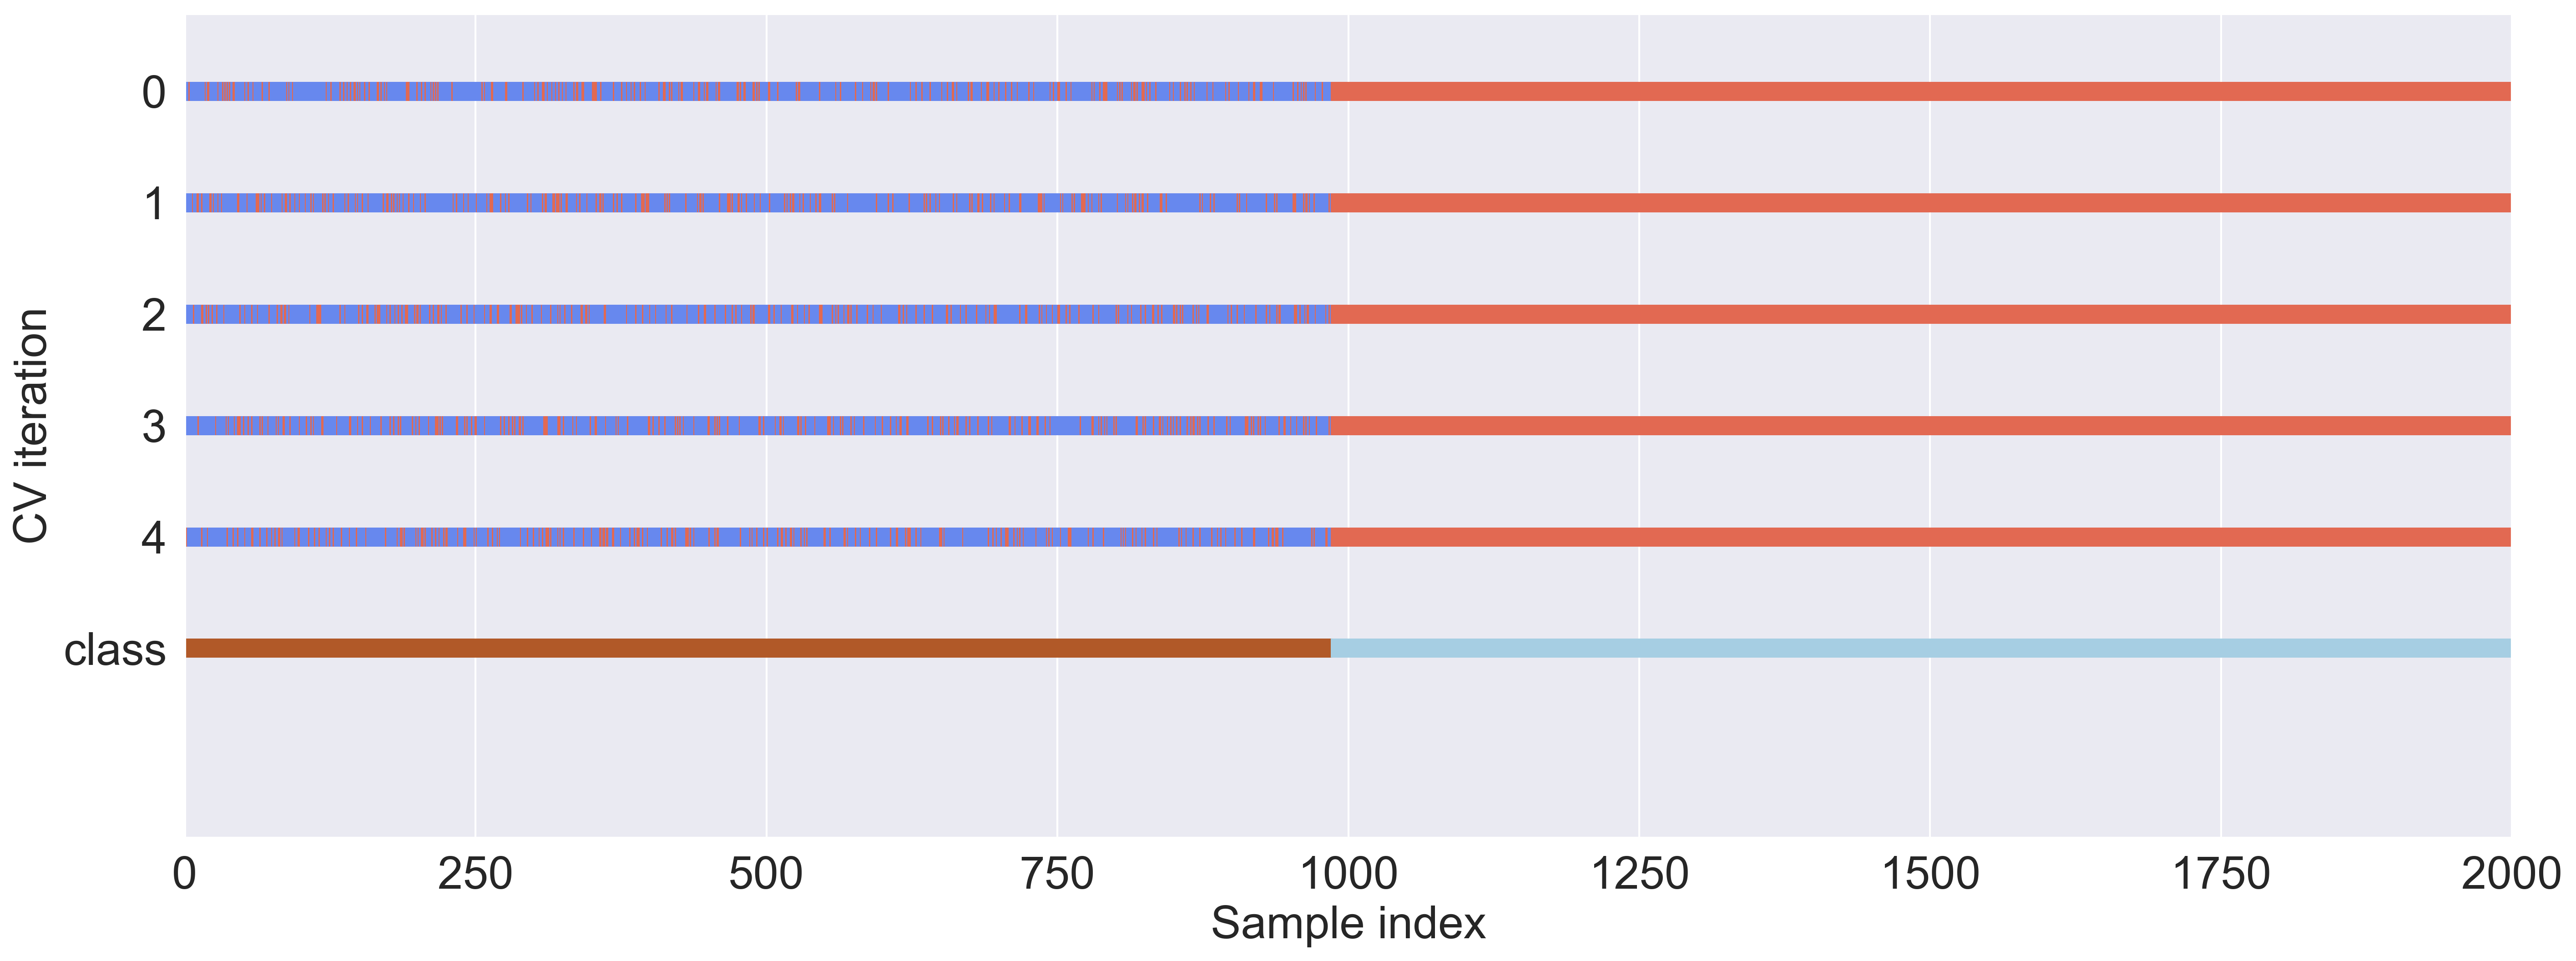

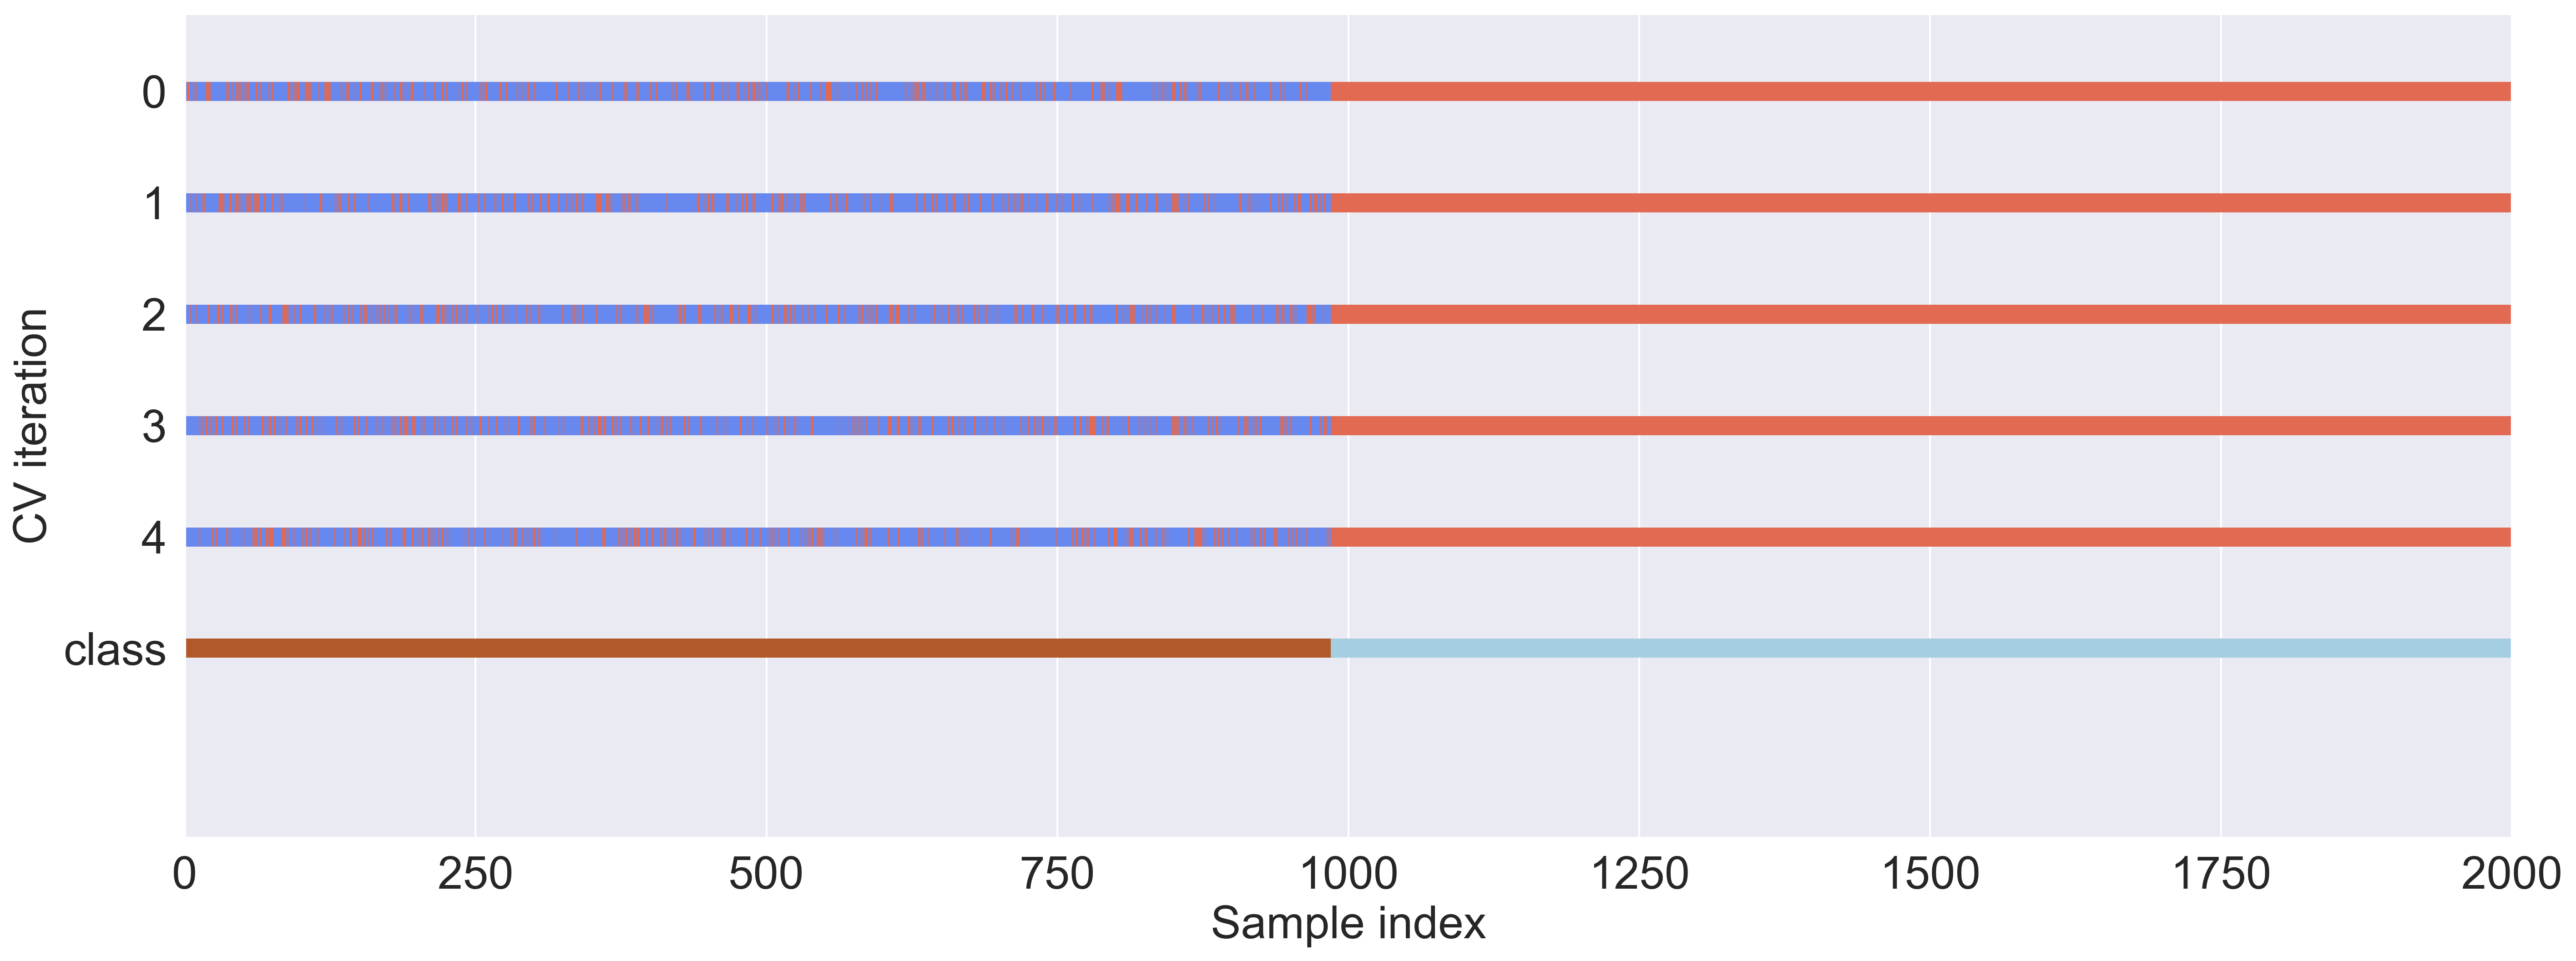

In [12]:
cv = RepeatedAnomalyShuffleSplit(Xpos, Xneg, n_splits=5, test_size=.2, n_repeats=n_repeats, random_state=random_state)

for cv_ in cv:
    fig, ax = plt.subplots()
    ax = plot_cv_indices(cv_, X, y, ax)
    ax.set(xlim=[0, 2000])

In [13]:
results = classification_benchmark(X=X, y=y,
                                   models=pipelines,
                                   cv=cv,
                                   scoring=scoring,
                                   random_state=random_state)

## Standard Setting as often used (80-20 split, 5-fold CV) does not yield highly similar results when the experiment is repeated

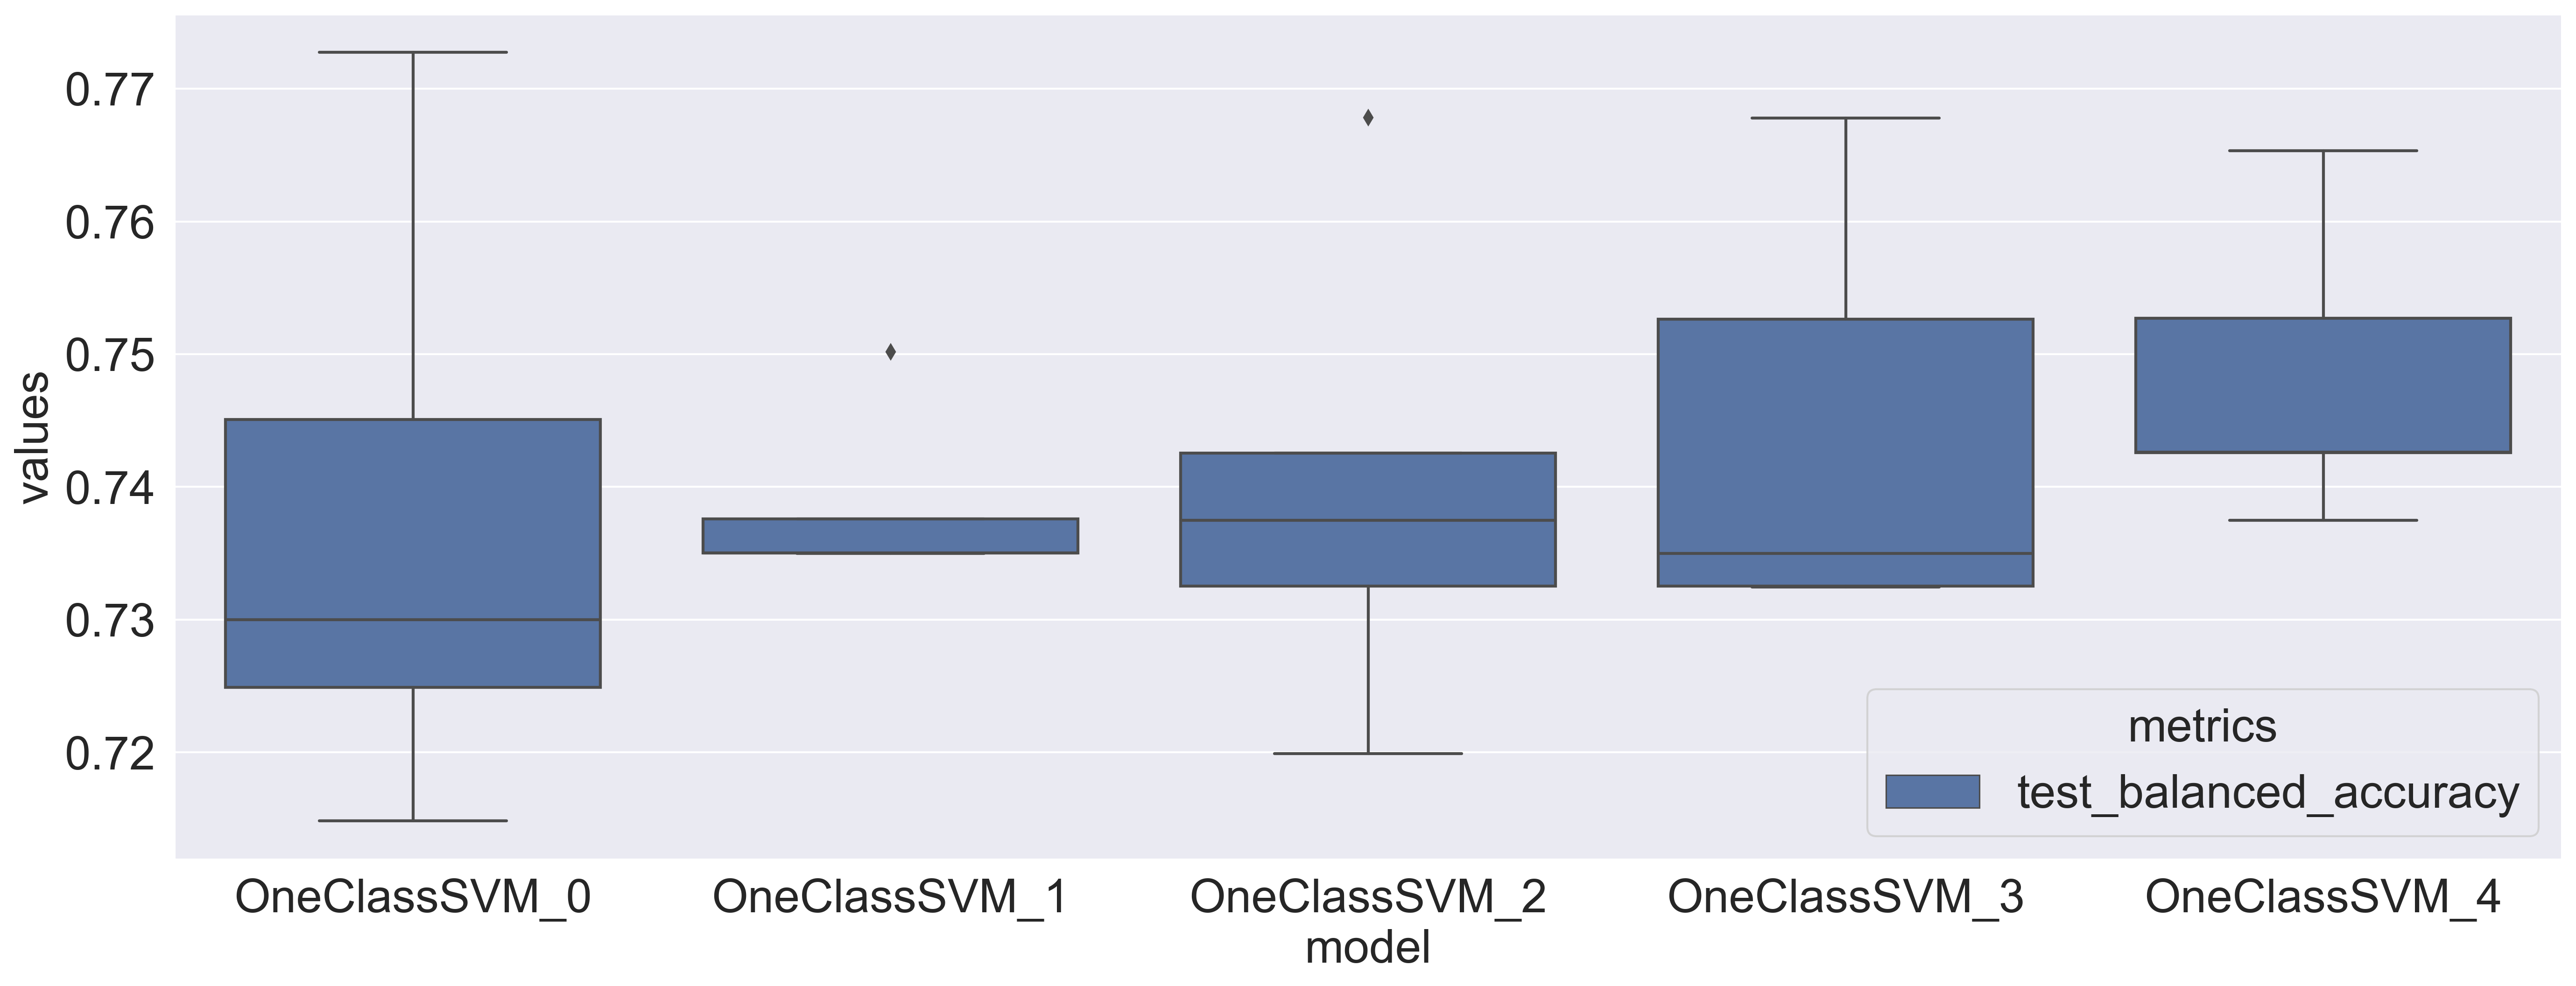

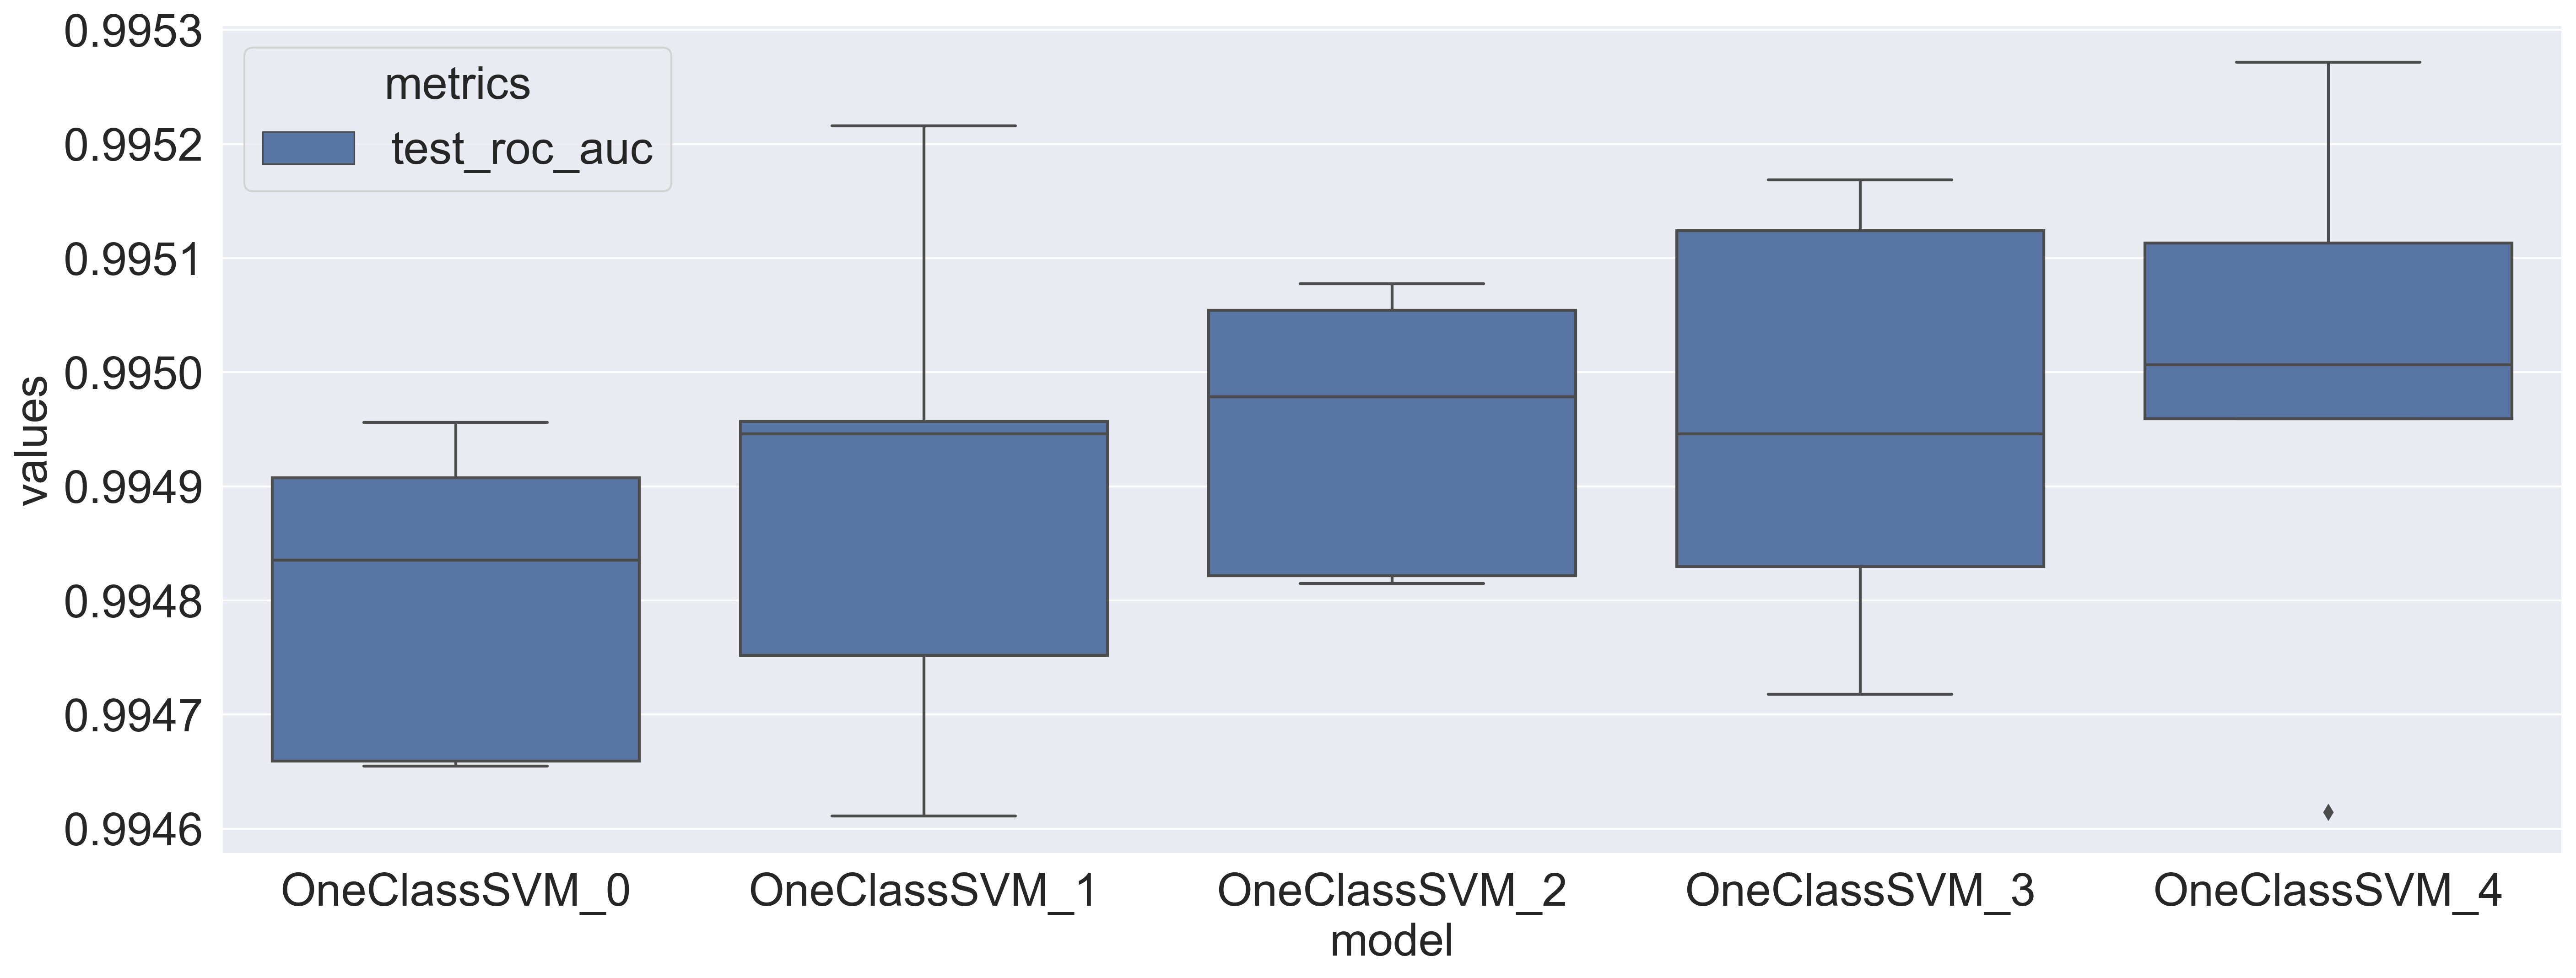

In [14]:
for key in results.columns[2:4]:
    fig = plot_metrics(extract_metrics(results, [key]))
    plt.show()

## Custom Setting does yield highly similar results, allowing for a fair comparisons and meaningful conclusions
We need to find a cross-validation setup that gives meaningful and reproducable results. In our case, 128 splits of 95% of the pristine samples for training and 5% for testing (plus all anomalous samples) seems to be sufficient.

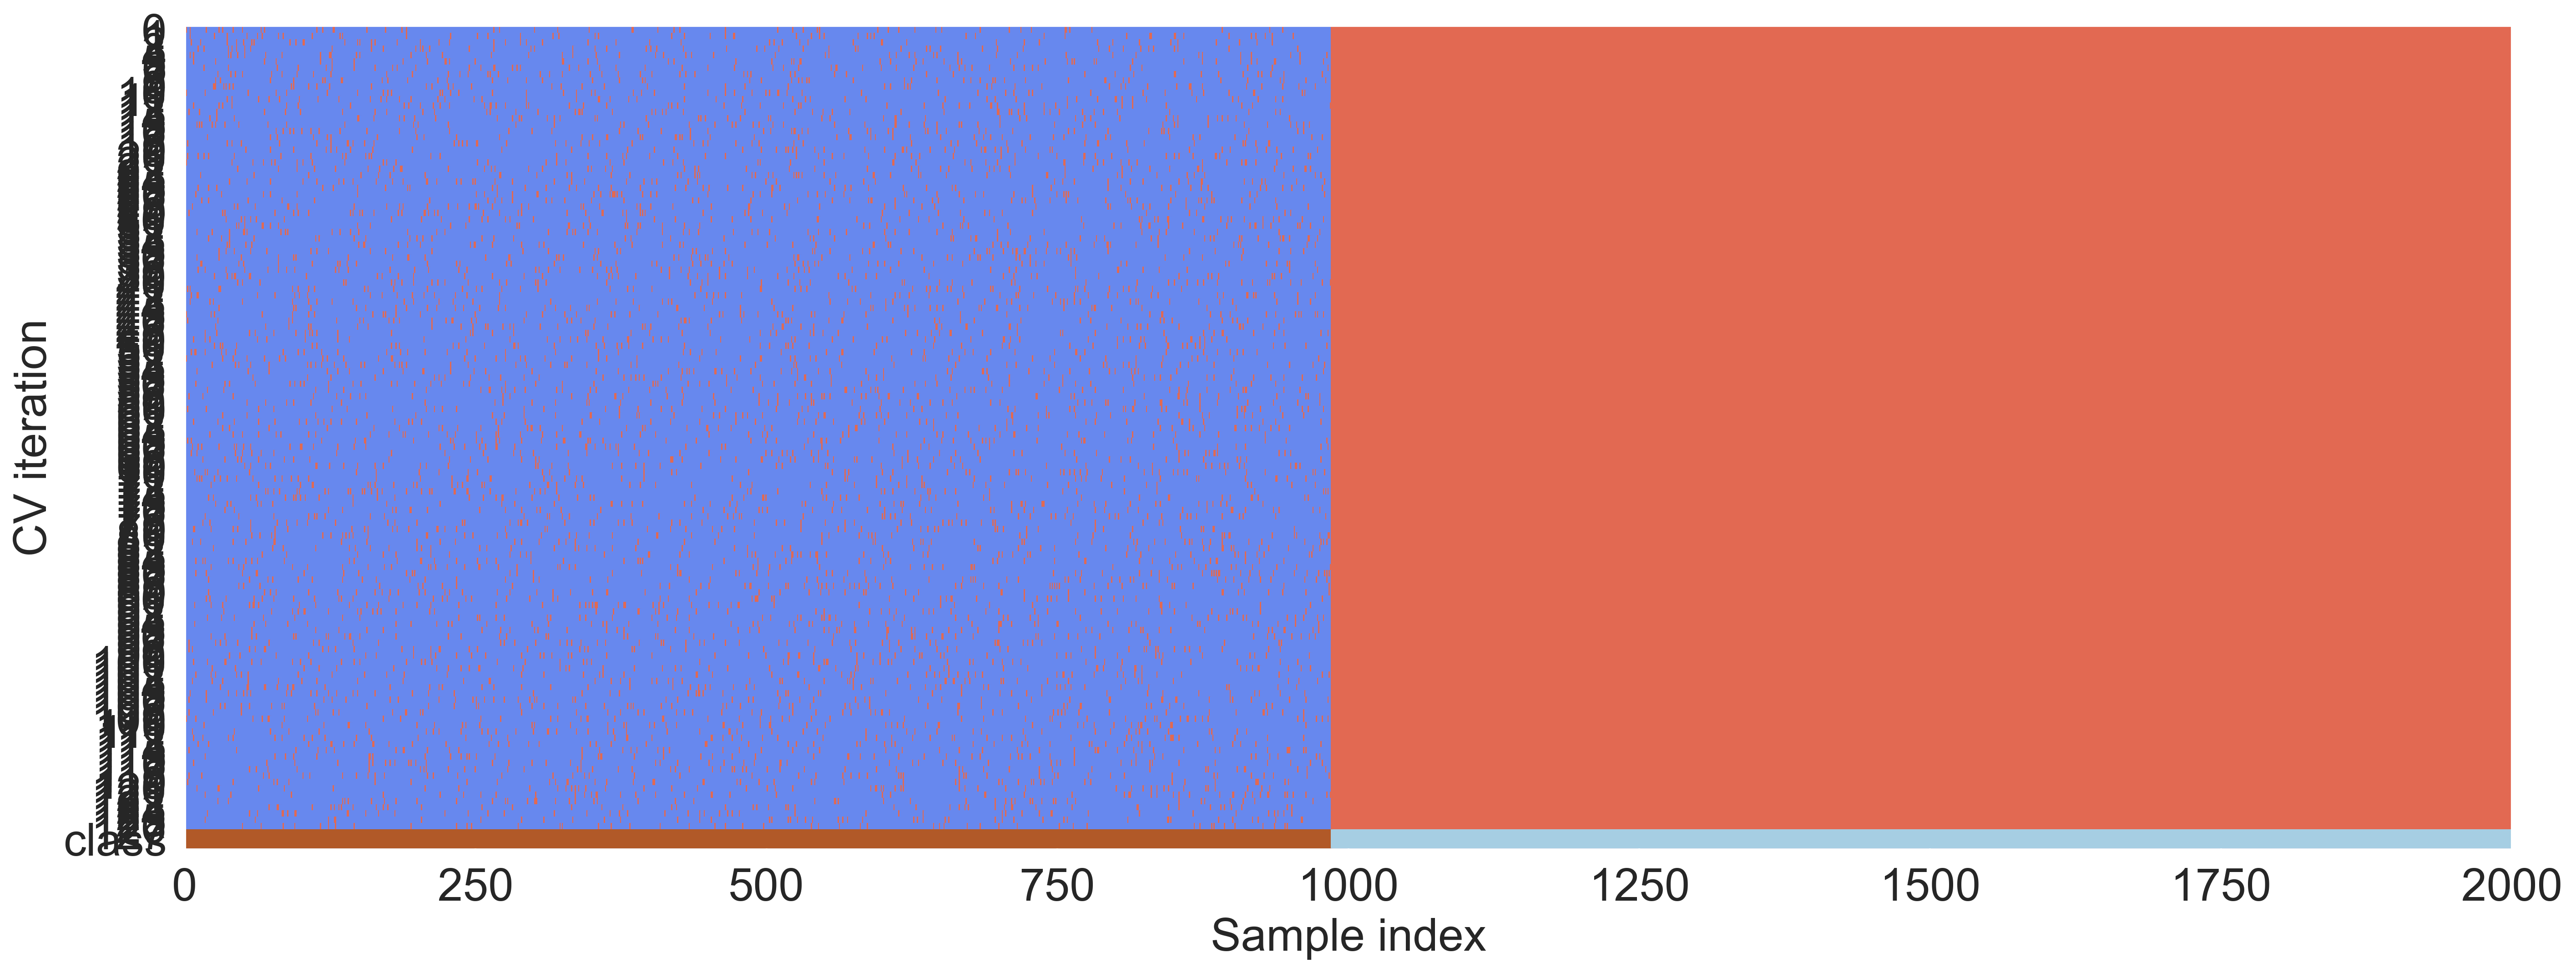

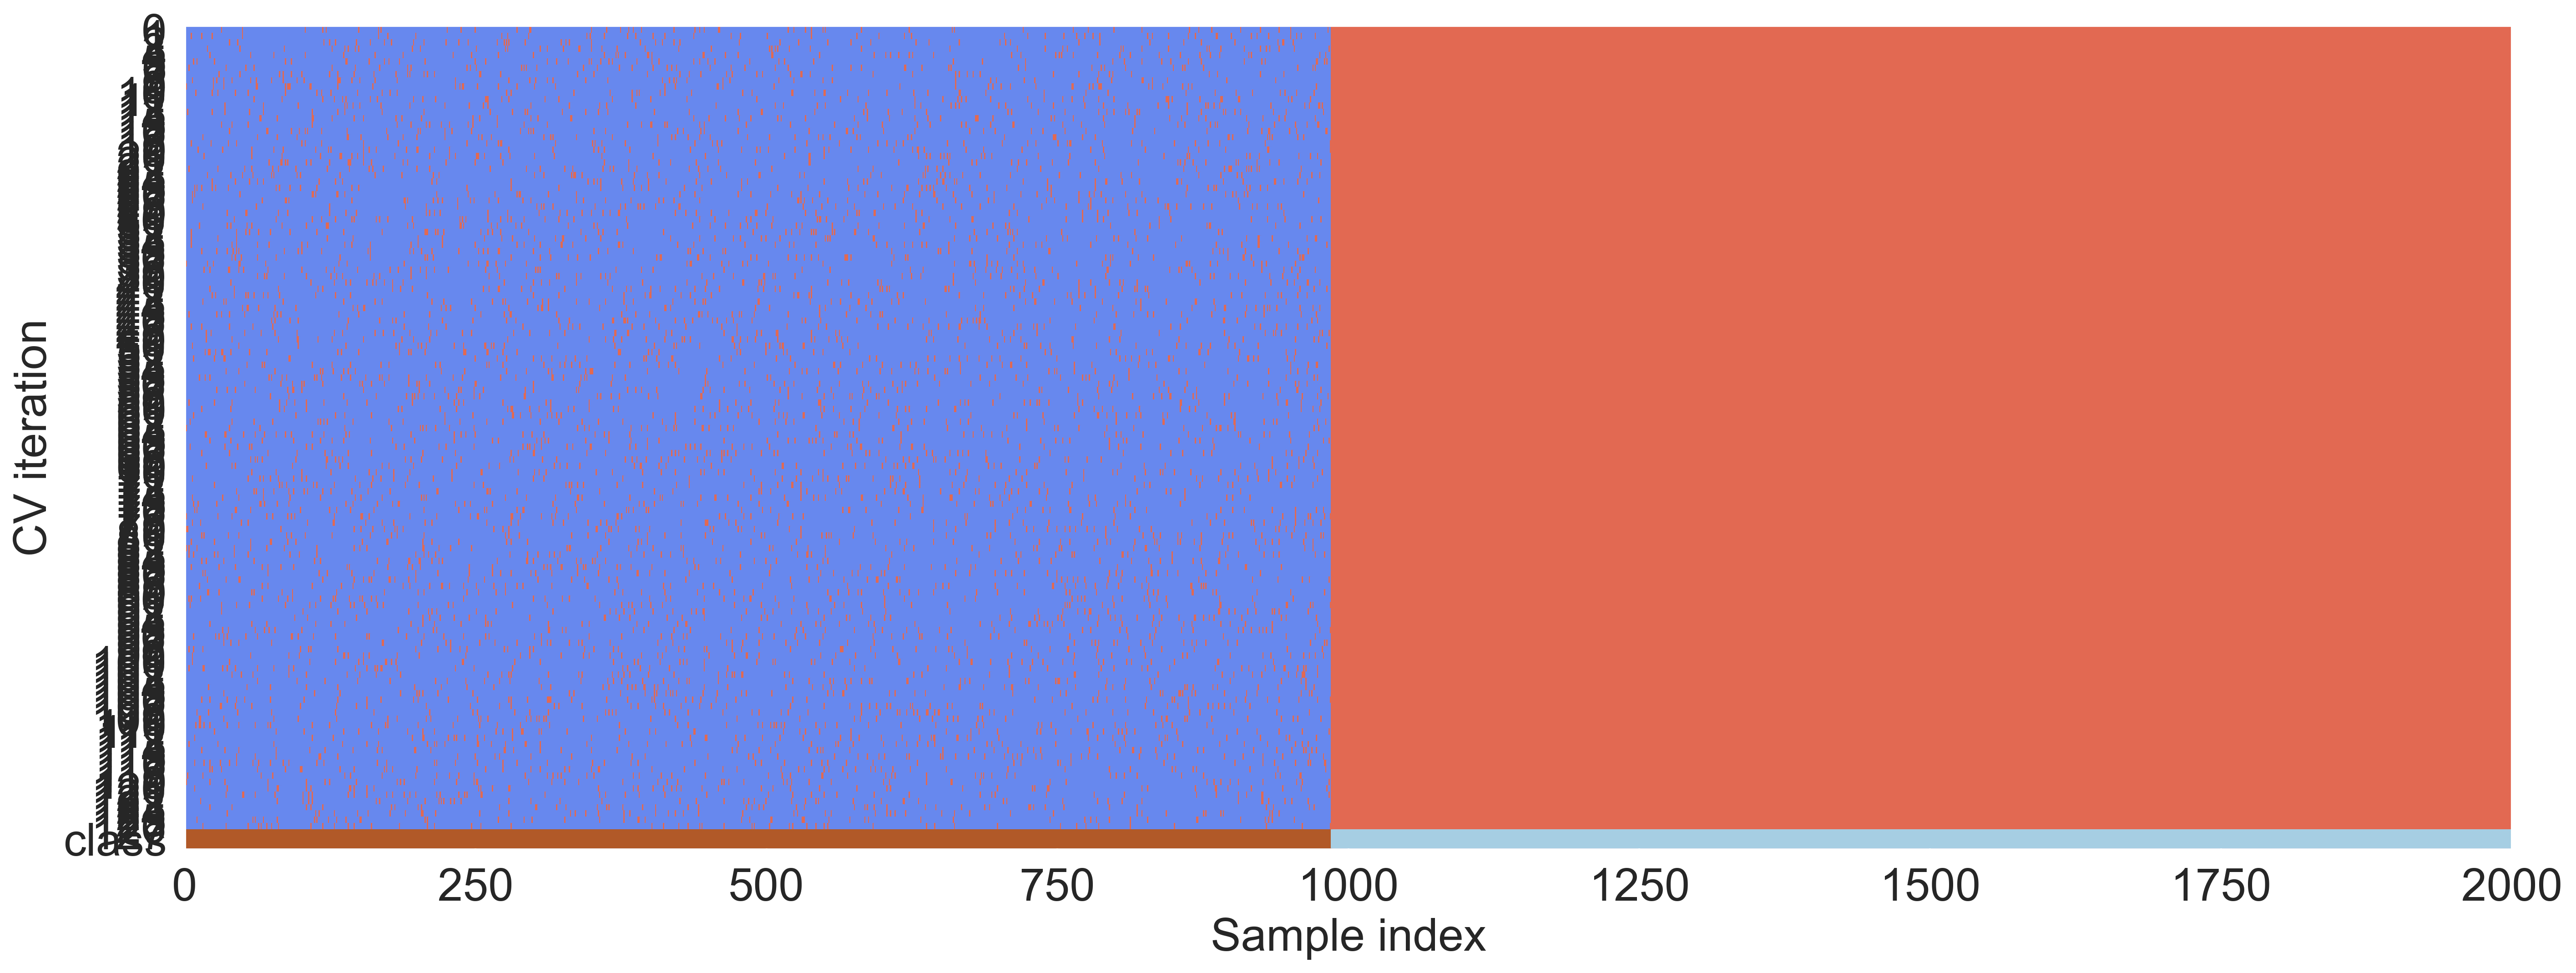

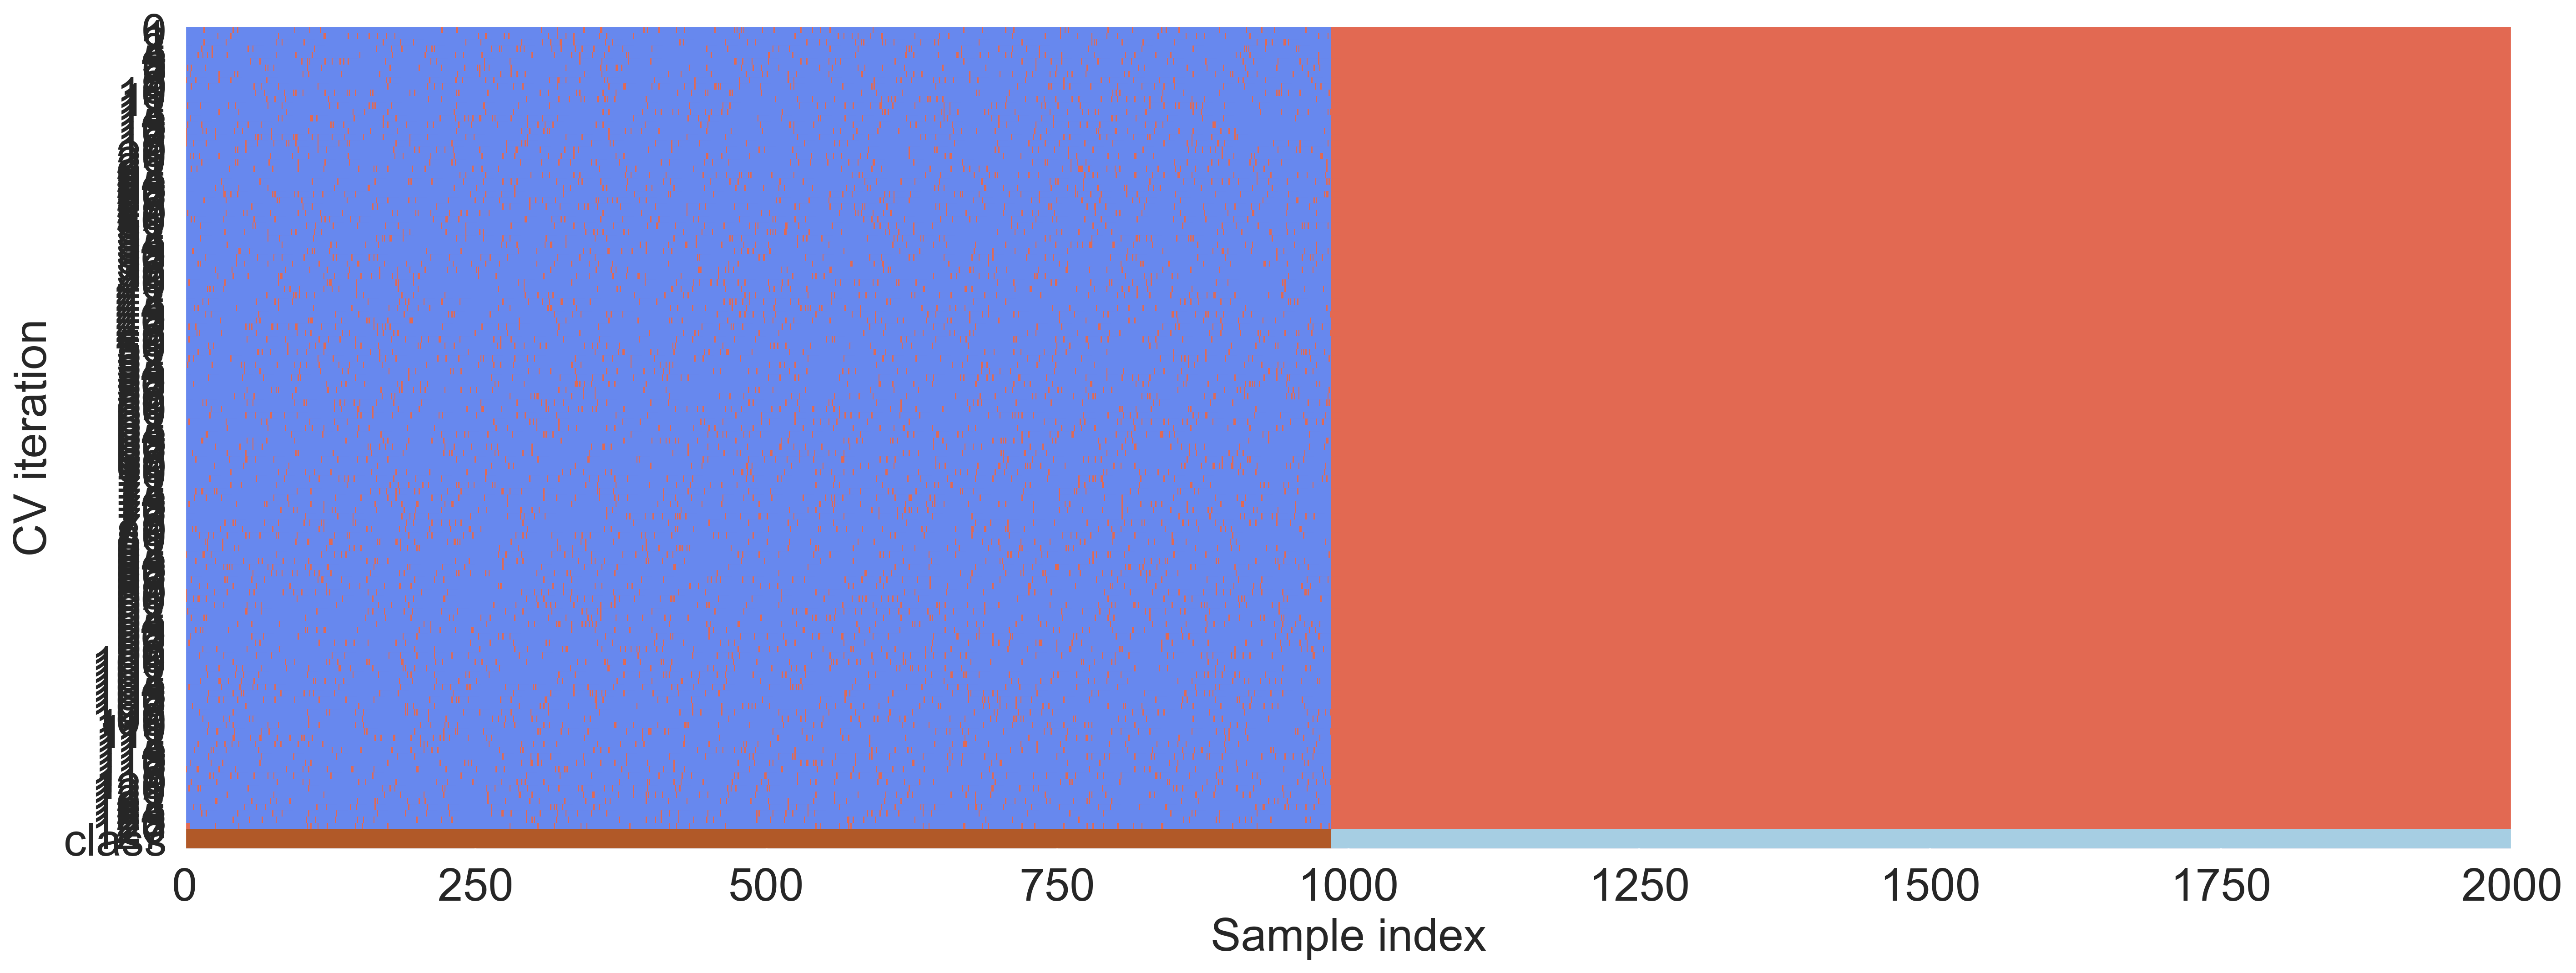

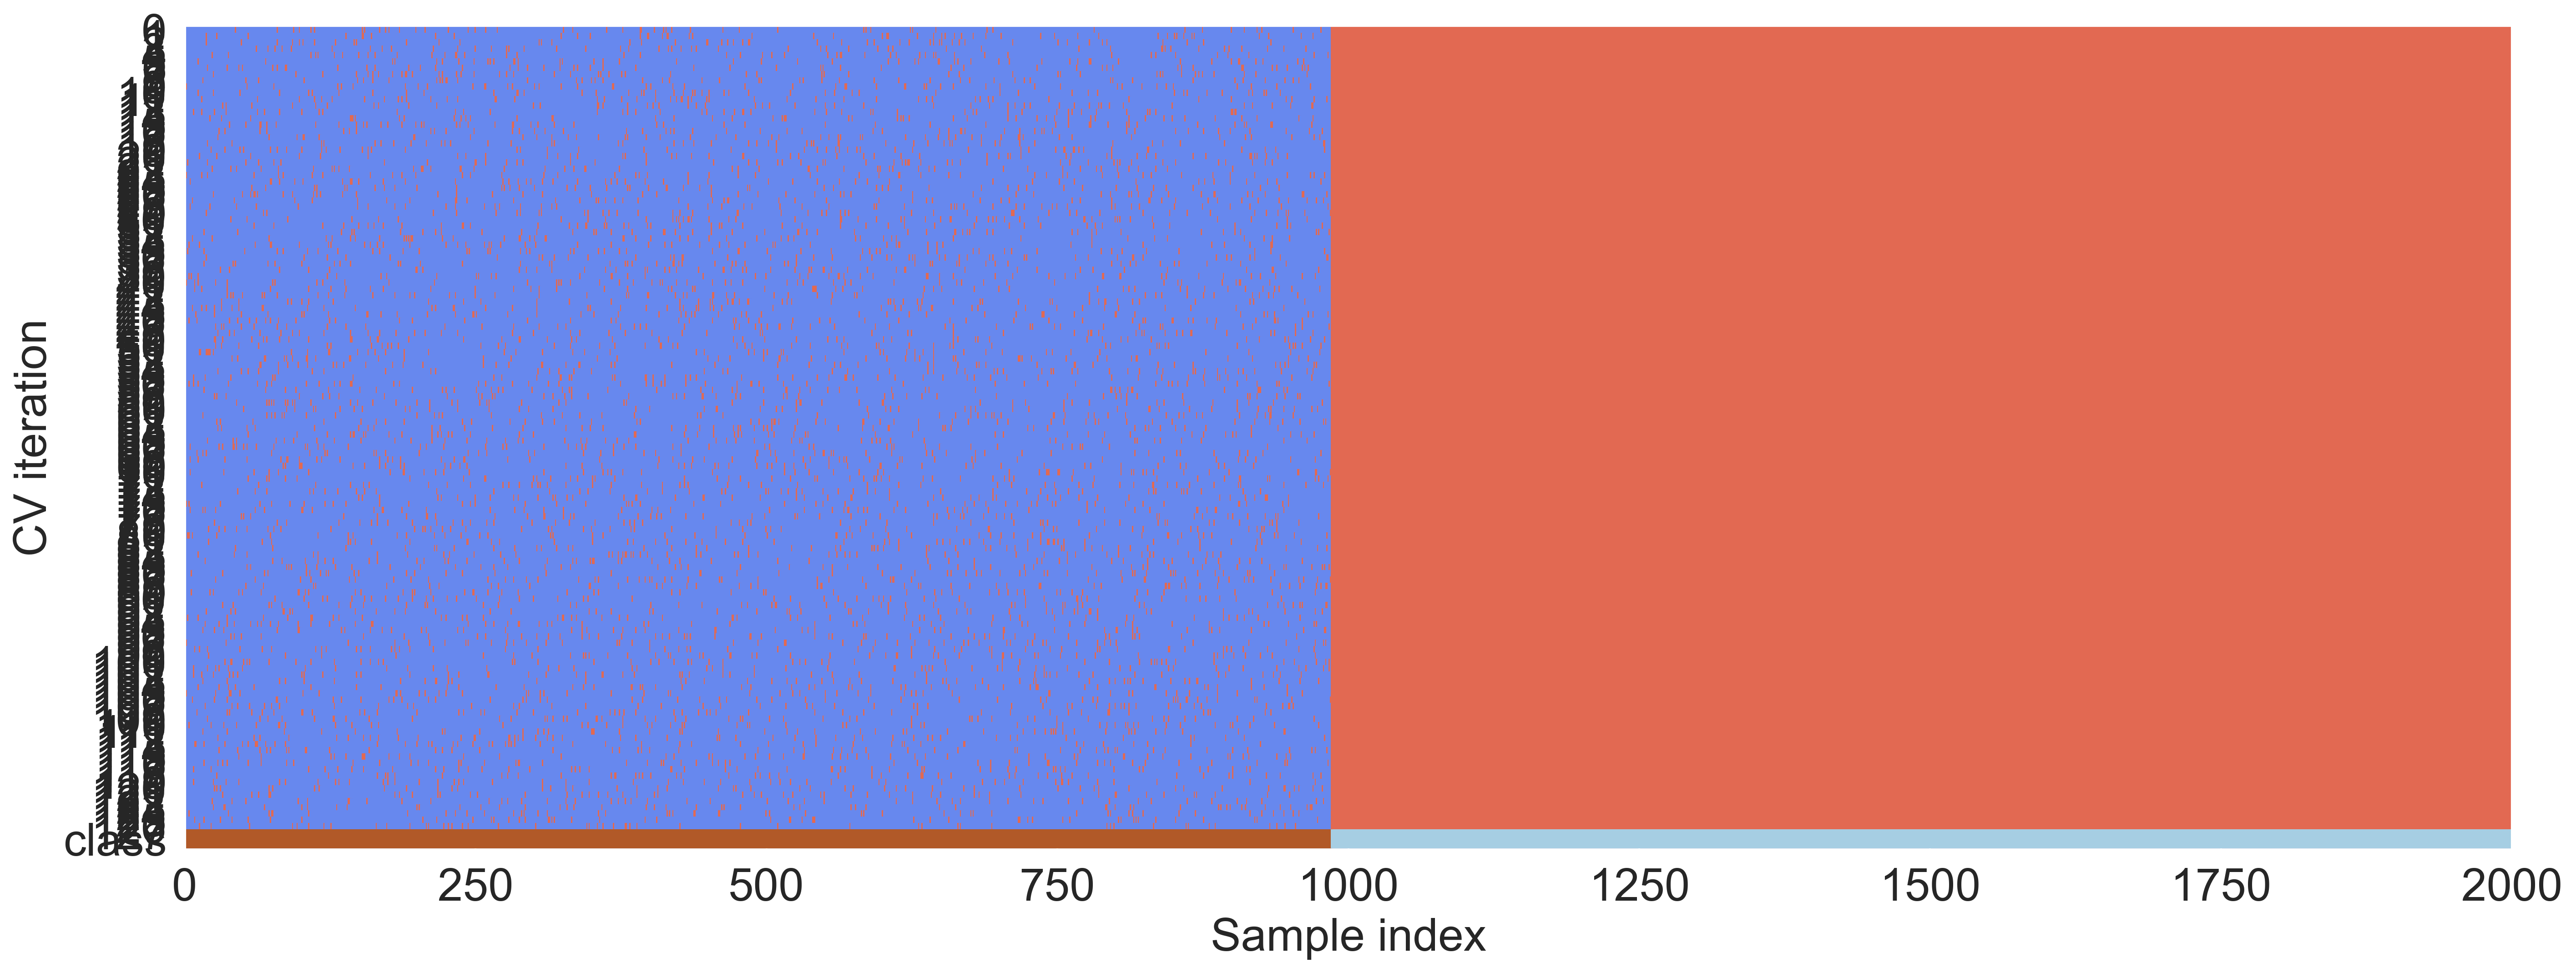

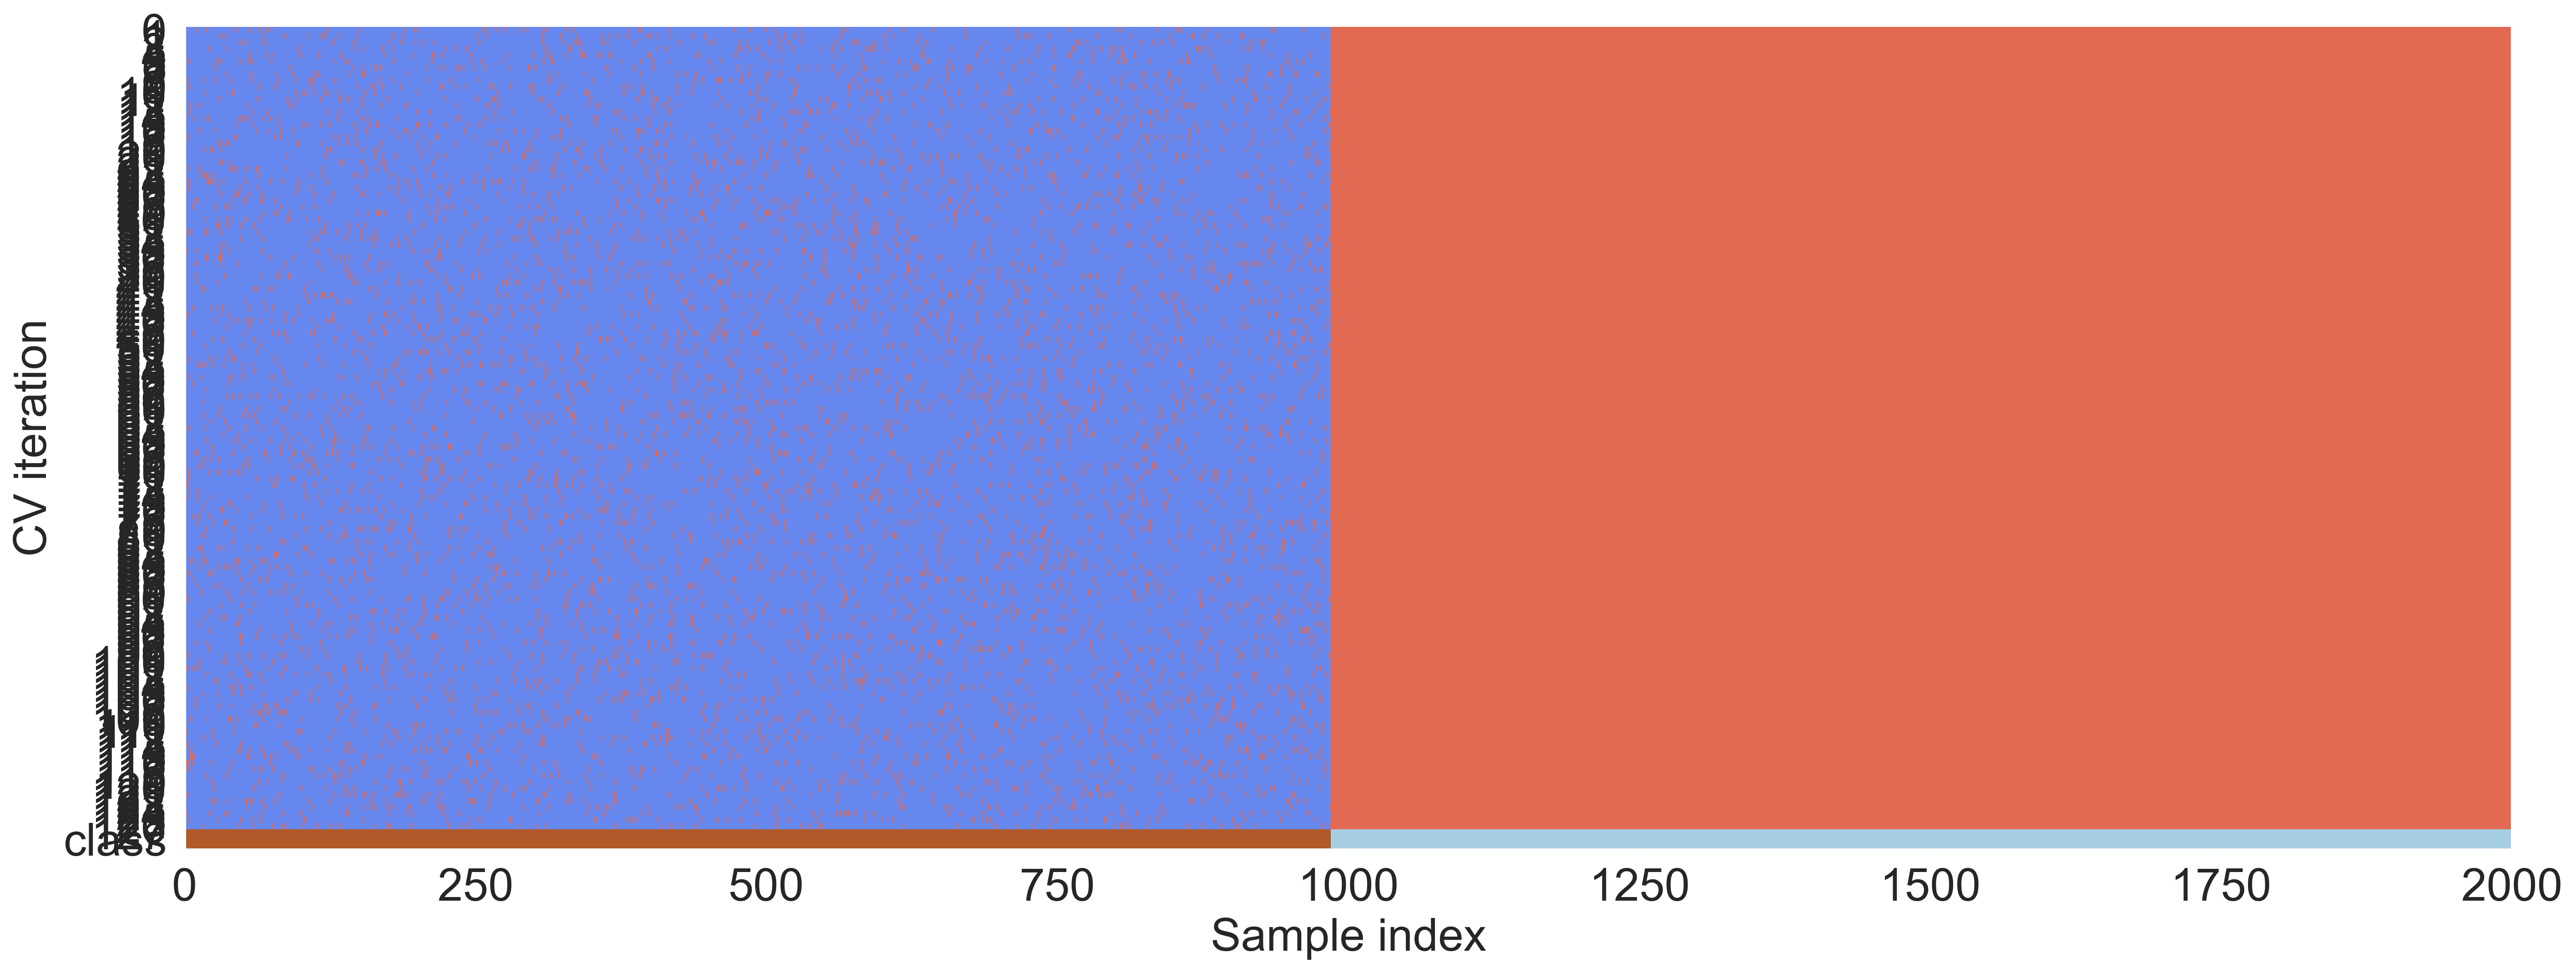

In [15]:
cv = RepeatedAnomalyShuffleSplit(Xpos, Xneg, n_splits=128, test_size=.05, n_repeats=n_repeats, random_state=random_state)

for cv_ in cv:
    fig, ax = plt.subplots()
    ax = plot_cv_indices(cv_, X, y, ax)
    ax.set(xlim=[0, 2000])

In [16]:
estimator = OneClassSVM(gamma='scale', nu=0.005)
pipeline = Pipeline([('est', estimator)])

n_repeats = 5
pipelines = repeat_experiment(pipeline, n_repeats=n_repeats, name="OneClassSVM")

In [17]:
results = classification_benchmark(X=X, y=y,
                                   models=pipelines,
                                   cv=cv,
                                   scoring=scoring,
                                   random_state=random_state)

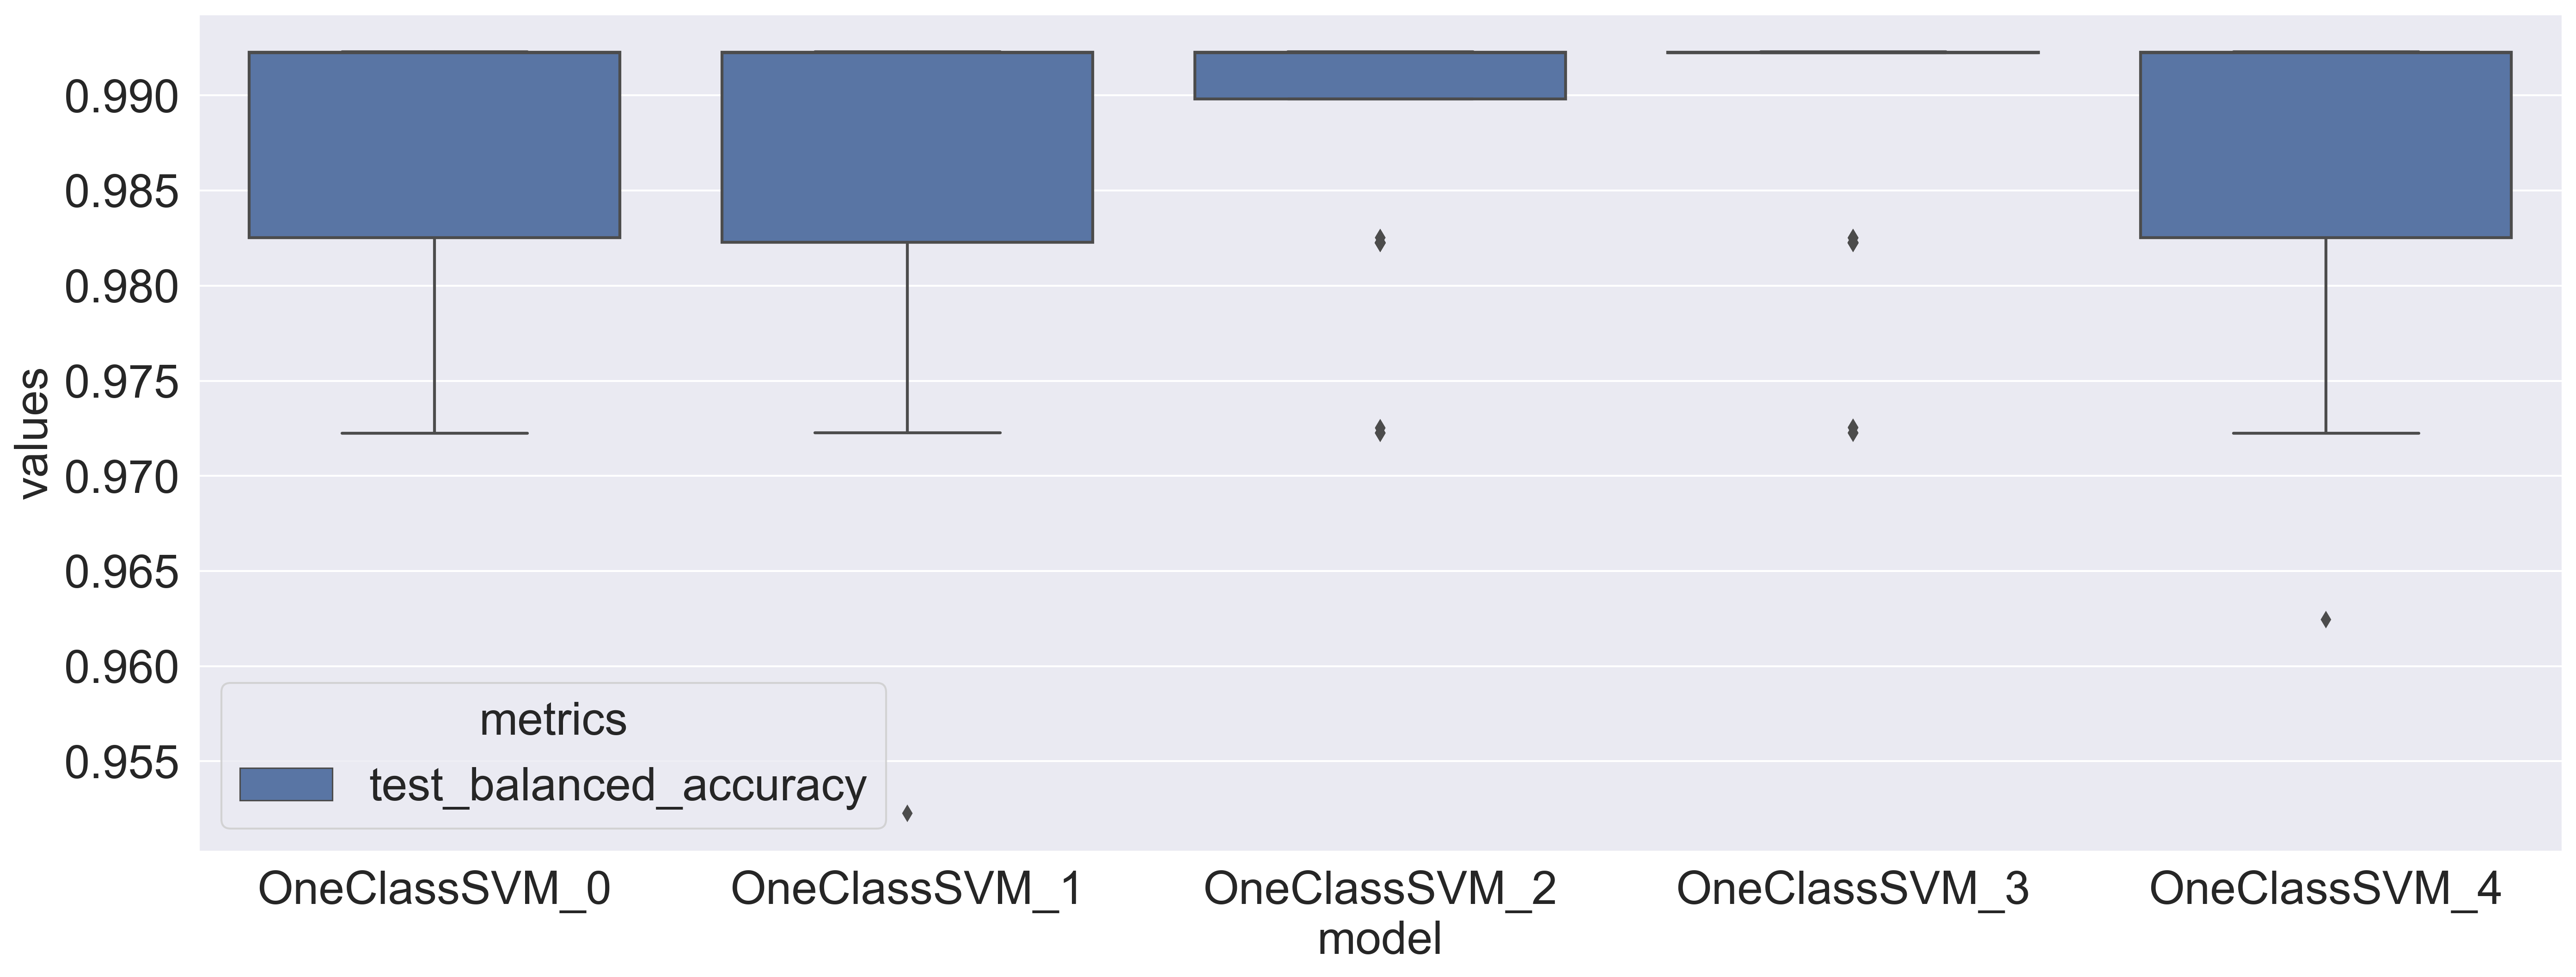

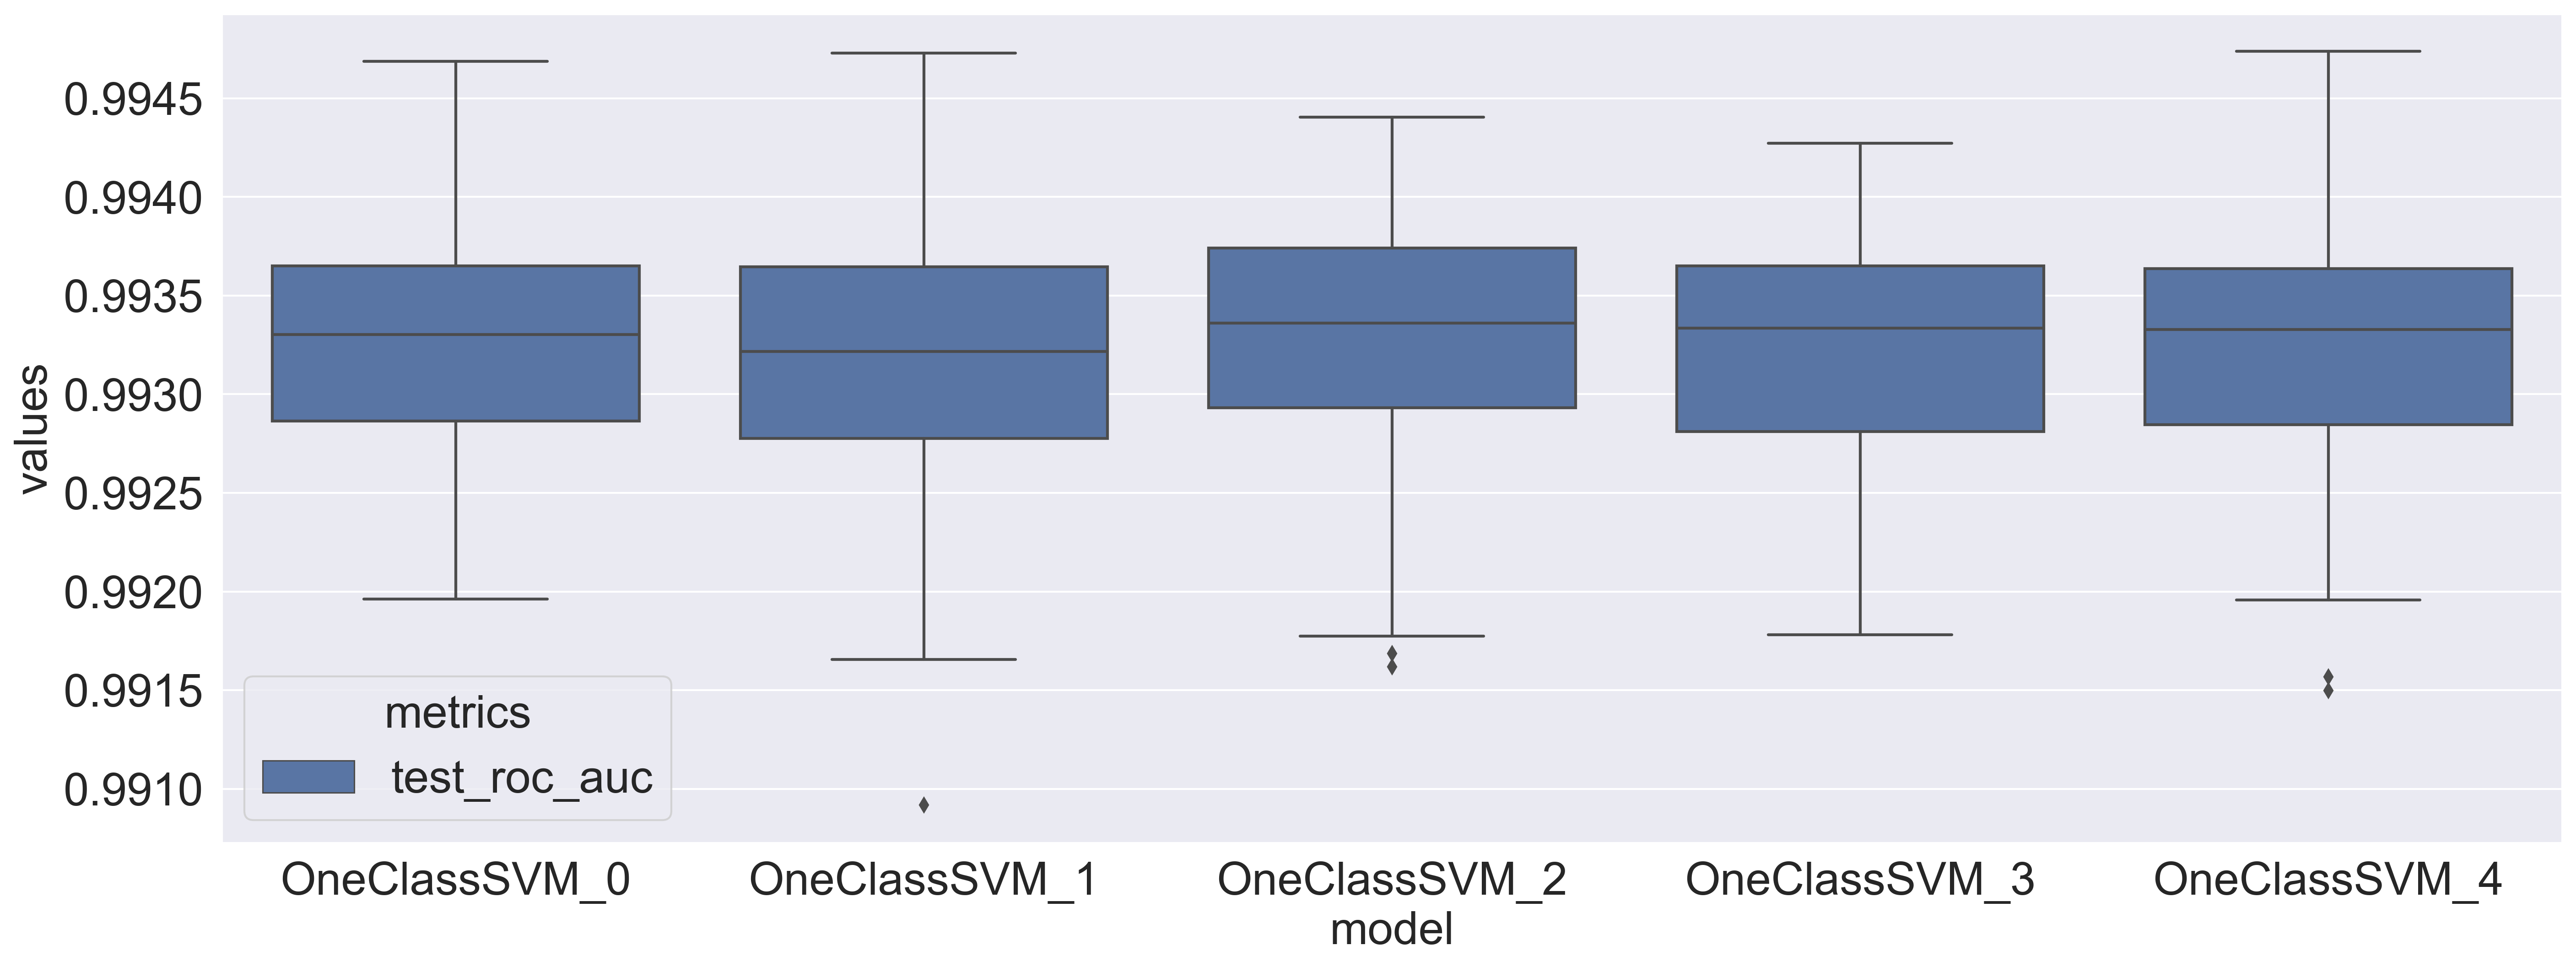

In [18]:
for key in results.columns[2:4]:
    fig = plot_metrics(extract_metrics(results, [key]))
    plt.show()